<h1><center>Deep Learning using TensorFlow</center></h1>

<h2>Abstract</h2>

Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.<br/>
I will apply a deep learning model to the data, and change the hyperparameters like activation function, cost function, epochs, gradient estimation, network architecture and initialization, to find the higher accuracy model. By the way, I will use Keras merged with Tensorflow (eg. tf.keras.layers.Conv2D). For each hyperparameters, I will try severl variables and see how does it effect the accuracy and how does it effect how quickly the network plateaus. 

## Approach

* For Part A:
    * Deep Learning model
* For Part B:
    * Activation function
* For Part C:
    * Cost function
* For Part D:
    * Epochs
* For Part E:
    * Gradient estimation
* For Part F:
    * Network Architecture
* For Part G:
    * Network initialization

## Dataset
Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.<br/>
The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. 
From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). <br/>
[https://www.kaggle.com/paultimothymooney/breast-histopathology-images](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)<br/>

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

To show the pictures' name which are compliance with naming rules.

In [2]:
imagePatches = glob('IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1351_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1501_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1551_class0.png


Resize the image and show it.

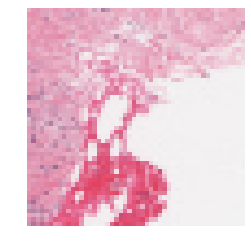

In [41]:
image_name = "IDC_regular_ps50_idx5/9135/1/9135_idx5_x1701_y1851_class1.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

Plot multiple images

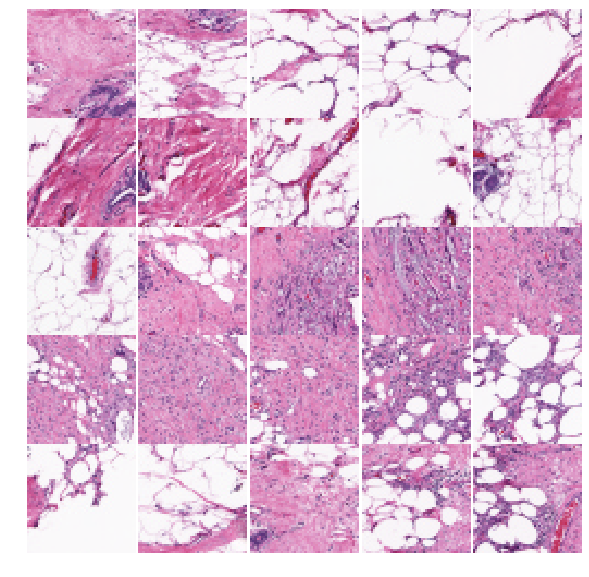

In [42]:
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Plot random images.

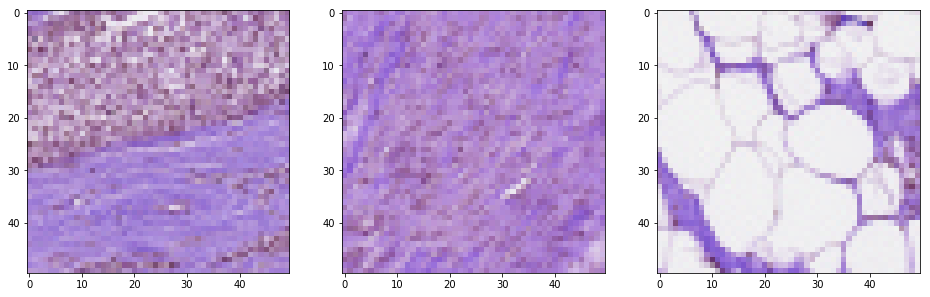

In [43]:
def randomImages(a):
    r = random.sample(a, 4)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
randomImages(imagePatches)

Three common data preprocessing steps are formatting, cleaning and sampling:

* Formatting: The data you have selected may not be in a format that is suitable for you to work with. The data may be in a relational database and you would like it in a flat file, or the data may be in a proprietary file format and you would like it in a relational database or a text file.
* Cleaning: Cleaning data is the removal or fixing of missing data. There may be data instances that are incomplete and do not carry the data you believe you need to address the problem. These instances may need to be removed. Additionally, there may be sensitive information in some of the attributes and these attributes may need to be anonymized or removed from the data entirely.
* Sampling: There may be far more selected data available than you need to work with. More data can result in much longer running times for algorithms and larger computational and memory requirements. You can take a smaller representative sample of the selected data that may be much faster for exploring and prototyping solutions before considering the whole dataset.

Preprocess the data. Rename them and make them into two classes.

In [3]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'IDC_regular_ps50_idx5\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y351_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x501_y401_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y301_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y351_class1.png', 'IDC_regular_ps50_idx5\\10253\\1\\10253_idx5_x551_y401_class1.png']


Definite the function to resize the photos into 50*50.

In [4]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

Preprocess 45,000 photos which I think is a good number.

In [5]:
X,Y = proc_images(0,45000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

Description of the data.

In [92]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 45000
Number of IDC(-) Images: 33393
Number of IDC(+) Images: 11607
Percentage of positive images: 25.79%
Image shape (Width, Height, Channels): (50, 50, 3)


The photos have been processed to be matrix.

In [9]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[206, 164, 226], [196, 154, 224], [211, 175,...       0
1  [[[197, 150, 219], [201, 158, 217], [205, 173,...       0
2  [[[249, 245, 248], [248, 246, 248], [253, 246,...       0
3  [[[249, 247, 249], [249, 247, 249], [249, 247,...       0
4  [[[237, 231, 241], [245, 242, 246], [235, 222,...       0
5  [[[248, 246, 248], [248, 246, 248], [248, 246,...       0
6  [[[175, 120, 212], [145, 88, 175], [132, 72, 1...       0
7  [[[87, 38, 142], [120, 94, 165], [195, 180, 21...       0
8  [[[235, 228, 240], [242, 240, 246], [252, 244,...       0
9  [[[238, 223, 242], [239, 235, 241], [250, 245,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


Plot one image with array.

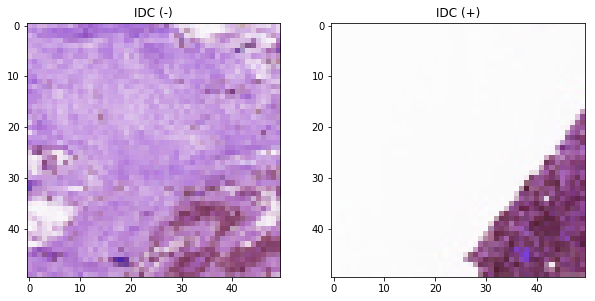

In [49]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[0])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[0])
plotOne(imgs0, imgs1) 

Plot multiple photos with arrays.

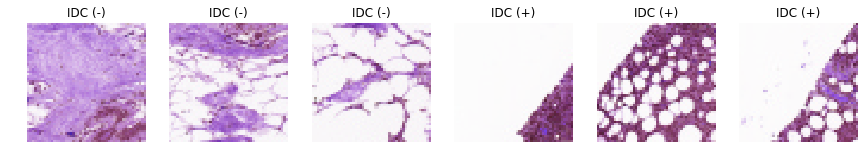

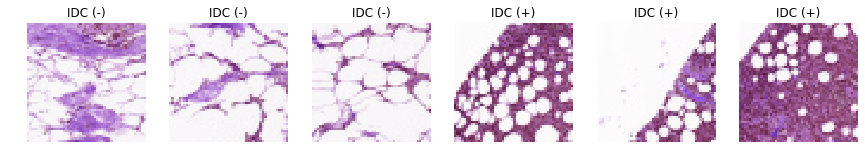

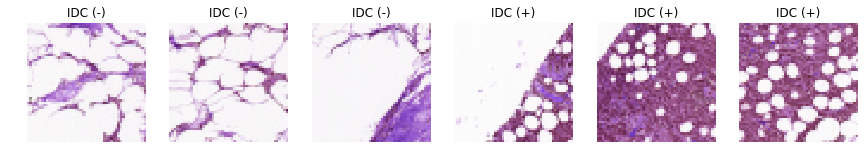

In [50]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

Plot image with its RGB Pixel Intensities.

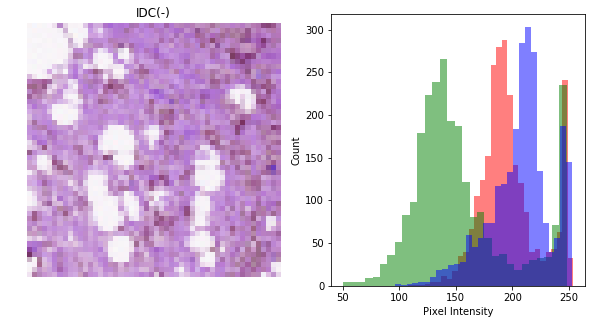

In [51]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

Split the data into training data and validation data. The data is scaled from 0 to 256 but we want it to be scaled from 0 to 1. 

In [6]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:300000] 
Y_train = Y_train[0:300000]
X_test = X_test[0:300000] 
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (36000, 50, 50, 3)
Testing Data Shape: (9000, 50, 50, 3)


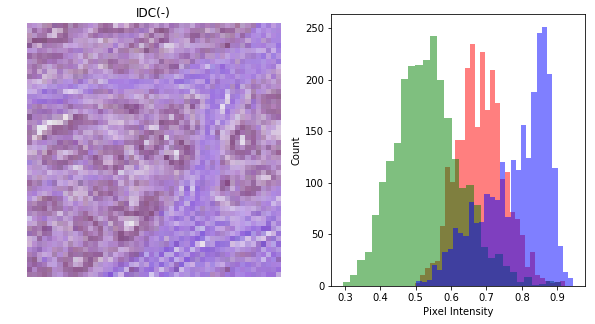

In [53]:
plotHistogram(X_train[100])

In [7]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

Show the numbers of data in each class.

{0: 'IDC(-)', 1: 'IDC(+)'}


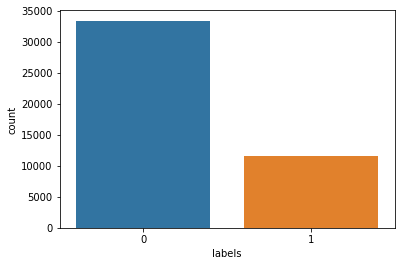

In [10]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

The imbalanced class sizes is not a good thing for training model, so I will fix it below.

{0: 'IDC(-)', 1: 'IDC(+)'}


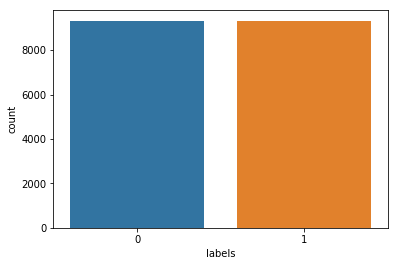

In [11]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [12]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [0.66500416 2.01511335]
New Class Weights:  [1. 1.]


Next I will plot a confusion matrix for the results that were produced by the Support Vector Machine in order to verify that we do not have too many false positives. I will also plot a learning curve to see if our model is overfitting or if our model has high bias.

In [11]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

<h2>Part A</h2>
-Deep Learning model (CNN)

In neural networks, Convolutional neural network (ConvNets or CNNs) is one of the main categories to do images recognition, images classifications. Objects detections, recognition faces etc., are some of the areas where CNNs are widely used.<br/>

CNN image classifications takes an input image, process it and classify it under certain categories (Eg., Dog, Cat, Tiger, Lion). Computers sees an input image as array of pixels and it depends on the image resolution. Based on the image resolution, it will see h x w x d( h = Height, w = Width, d = Dimension ). Eg., An image of 6 x 6 x 3 array of matrix of RGB (3 refers to RGB values) and an image of 4 x 4 x 1 array of matrix of grayscale image.<br/>

Technically, deep learning CNN models to train and test, each input image will pass it through a series of convolution layers with filters (Kernals), Pooling, fully connected layers (FC) and apply Softmax function to classify an object with probabilistic values between 0 and 1. The below figure is a complete flow of CNN to process an input image and classifies the objects based on values.

<img src="image1.jpeg">

What is an Activation Function?<br/>
Activation functions are an extremely important feature of the artificial neural networks. They basically decide whether a neuron should be activated or not. Whether the information that the neuron is receiving is relevant for the given information or should it be ignored.
The activation function is the non linear transformation that we do over the input signal. This transformed output is then sen to the next layer of neurons as input.

What’s a Loss Function?<br/>
At its core, a loss function is incredibly simple: it’s a method of evaluating how well your algorithm models your dataset. If your predictions are totally off, your loss function will output a higher number. If they’re pretty good, it’ll output a lower number. As you change pieces of your algorithm to try and improve your model, your loss function will tell you if you’re getting anywhere.

What’s a Epoch?<br/>
When you train your neural network for example, or evaluate it, you do the feedforward not only with one sample but with a lot of them, that’s what we call a batch. You’re gonna feed forward your NN with all your batches. Using all your batches once is 1 epoch. If you have 10 epochs it mean that you’re gonna use all your data 10 times (split in batches).

What is Gradient Descent?<br/>
Gradient descent is one of the most popular algorithms to perform optimization and by far the most common way to optimize neural networks. At the same time, every state-of-the-art Deep Learning library contains implementations of various algorithms to optimize gradient descent (e.g. lasagne's, caffe's, and keras' documentation). These algorithms, however, are often used as black-box optimizers, as practical explanations of their strengths and weaknesses are hard to come by.

What is Kernel Initializer?<br/>
The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights.

This is the first model. The input data is 50 * 50 * 3. It has two convolution layers, one maxpooling layer and two dense. In order to prevent overfitting，the model dropout twice with 0.25 and 0.5. The epochs are 30. I will plot the change of loss and accuracy which can let us see the change clearly. 

activation: relu; loss: categorical_crossentropy; optimizer: Adadelta

In mathematics, the softmax function, also known as softargmax[1] or normalized exponential function,[2]:198 is a function that takes as input a vector of K real numbers, and normalizes it into a probability distribution consisting of K probabilities. That is, prior to applying softmax, some vector components could be negative, or greater than one; and might not sum to 1; but after applying softmax, each component will be in the interval {\displaystyle (0,1)} (0,1), and the components will add up to 1, so that they can be interpreted as probabilities. Furthermore, the larger input components will correspond to larger probabilities. Softmax is often used in neural networks, to map the non-normalized output of a network to a probability distribution over predicted output classes.

Epoch 1/30
583/583 [==============================] - 28s 48ms/step - loss: 0.5460 - acc: 0.7315 - val_loss: 0.4601 - val_acc: 0.8000
Epoch 2/30
583/583 [==============================] - 27s 47ms/step - loss: 0.4521 - acc: 0.8023 - val_loss: 0.5597 - val_acc: 0.7555
Epoch 3/30
583/583 [==============================] - 28s 47ms/step - loss: 0.4356 - acc: 0.8125 - val_loss: 0.4512 - val_acc: 0.7994
Epoch 4/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4244 - acc: 0.8172 - val_loss: 0.4175 - val_acc: 0.8156
Epoch 5/30
583/583 [==============================] - 28s 47ms/step - loss: 0.4179 - acc: 0.8196 - val_loss: 0.4244 - val_acc: 0.8140
Epoch 6/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4086 - acc: 0.8283 - val_loss: 0.4087 - val_acc: 0.8206
Epoch 7/30
583/583 [==============================] - 28s 47ms/step - loss: 0.4046 - acc: 0.8277 - val_loss: 0.3889 - val_acc: 0.8315
Epoch 8/30
583/583 [==============================] - 28s 48ms

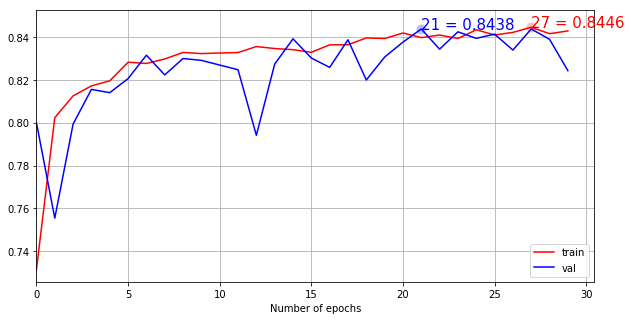

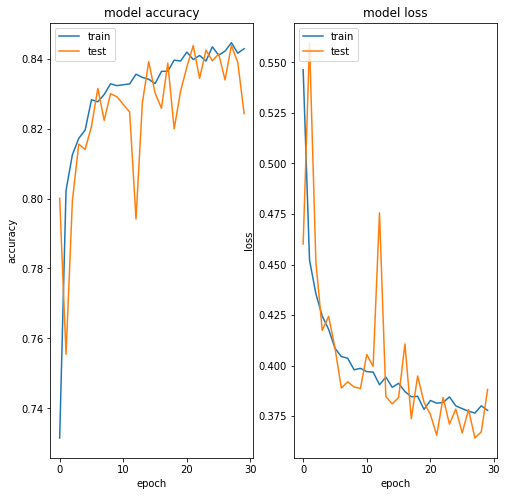


Epoch: 27 , Accuracy: 0.84375


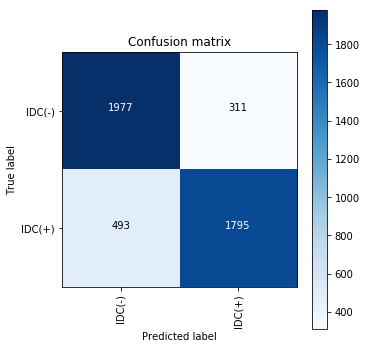

In [100]:
def runKerasCNNAugment(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

I do research about the plateaus. There is no clear definition about the neatwork plateaus. So I think the loss has not changed much. When it is relatively stable, it has reached plateaus.

We can find the accuracy is 84.38%. When the model is 7 epoch， it reached plateaus. 

<h2>Part B</h2>
- Activation function

Change the activation function (use at least two). How does it effect the accuracy?<br/>
How does it effect how quickly the network plateaus?

In Part B, I will change the activation function which is the only parameter I will change and compare them how to effect the accuracy and how quickly the wetwork plateaus.

Activation function: tanh

Epoch 1/30
583/583 [==============================] - 29s 49ms/step - loss: 0.5943 - acc: 0.7210 - val_loss: 0.4712 - val_acc: 0.7887
Epoch 2/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4776 - acc: 0.7852 - val_loss: 0.4603 - val_acc: 0.8038
Epoch 3/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4628 - acc: 0.7935 - val_loss: 0.4681 - val_acc: 0.7806
Epoch 4/30
583/583 [==============================] - 28s 49ms/step - loss: 0.4529 - acc: 0.8008 - val_loss: 0.4538 - val_acc: 0.8083
Epoch 5/30
583/583 [==============================] - 29s 49ms/step - loss: 0.4458 - acc: 0.8029 - val_loss: 0.4539 - val_acc: 0.8066
Epoch 6/30
583/583 [==============================] - 30s 52ms/step - loss: 0.4376 - acc: 0.8053 - val_loss: 0.4315 - val_acc: 0.8112
Epoch 7/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4353 - acc: 0.8093 - val_loss: 0.4768 - val_acc: 0.7858
Epoch 8/30
583/583 [==============================] - 29s 49ms

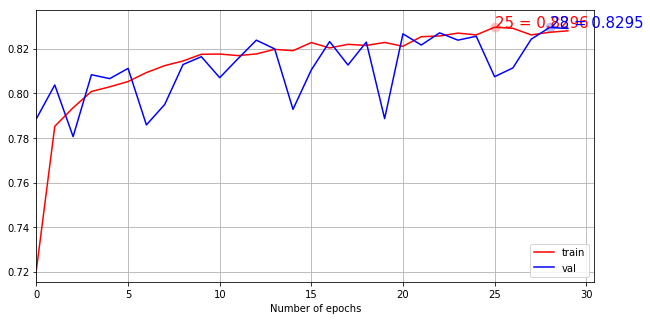

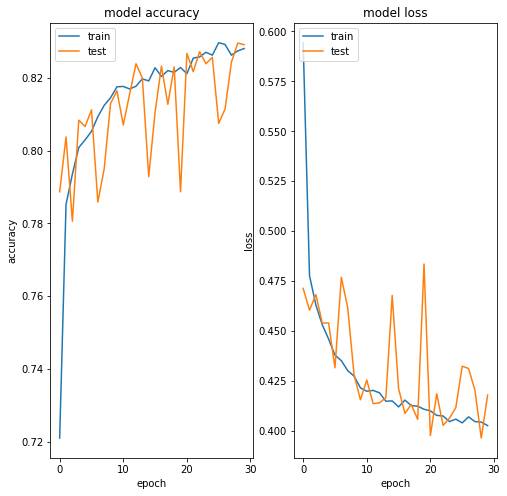


Epoch: 28 , Accuracy: 0.82954544


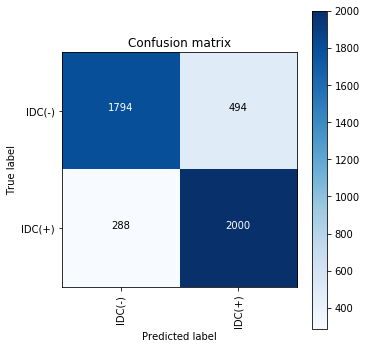

In [101]:
def runKerasCNNAugment_1(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='tanh',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment_1(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Activation function: LeakyReLU

Epoch 1/30
583/583 [==============================] - 29s 49ms/step - loss: 0.5393 - acc: 0.7420 - val_loss: 0.4441 - val_acc: 0.8009
Epoch 2/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4574 - acc: 0.8029 - val_loss: 0.4641 - val_acc: 0.8042
Epoch 3/30
583/583 [==============================] - 29s 49ms/step - loss: 0.4385 - acc: 0.8093 - val_loss: 0.4179 - val_acc: 0.8158
Epoch 4/30
583/583 [==============================] - 29s 49ms/step - loss: 0.4311 - acc: 0.8141 - val_loss: 0.4131 - val_acc: 0.8153
Epoch 5/30
583/583 [==============================] - 28s 49ms/step - loss: 0.4221 - acc: 0.8184 - val_loss: 0.4138 - val_acc: 0.8160
Epoch 6/30
583/583 [==============================] - 29s 49ms/step - loss: 0.4162 - acc: 0.8214 - val_loss: 0.4044 - val_acc: 0.8258
Epoch 7/30
583/583 [==============================] - 29s 49ms/step - loss: 0.4120 - acc: 0.8228 - val_loss: 0.4007 - val_acc: 0.8252
Epoch 8/30
583/583 [==============================] - 29s 50ms

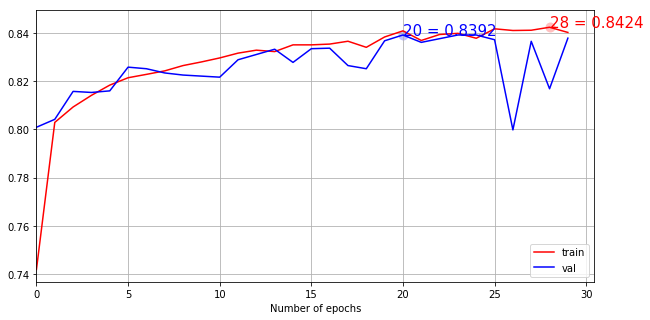

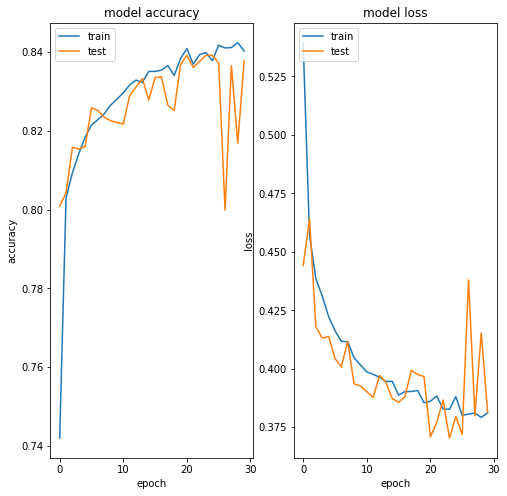


Epoch: 23 , Accuracy: 0.83916086


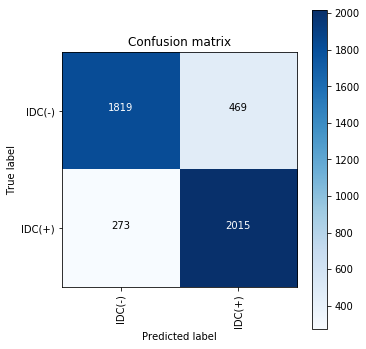

In [103]:
def runKerasCNNAugment_2(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.LeakyReLU(alpha=0.1),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data =(c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment_2(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Activation function: PReLU

Epoch 1/30
583/583 [==============================] - 36s 62ms/step - loss: 0.5400 - acc: 0.7424 - val_loss: 0.4522 - val_acc: 0.8049
Epoch 2/30
583/583 [==============================] - 36s 61ms/step - loss: 0.4515 - acc: 0.8035 - val_loss: 0.4337 - val_acc: 0.8005
Epoch 3/30
583/583 [==============================] - 37s 64ms/step - loss: 0.4309 - acc: 0.8152 - val_loss: 0.4566 - val_acc: 0.8053
Epoch 4/30
583/583 [==============================] - 37s 63ms/step - loss: 0.4234 - acc: 0.8182 - val_loss: 0.4187 - val_acc: 0.8153
Epoch 5/30
583/583 [==============================] - 36s 61ms/step - loss: 0.4174 - acc: 0.8207 - val_loss: 0.4416 - val_acc: 0.8132
Epoch 6/30
583/583 [==============================] - 36s 62ms/step - loss: 0.4121 - acc: 0.8237 - val_loss: 0.3974 - val_acc: 0.8230
Epoch 7/30
583/583 [==============================] - 36s 62ms/step - loss: 0.4055 - acc: 0.8263 - val_loss: 0.4118 - val_acc: 0.8132
Epoch 8/30
583/583 [==============================] - 36s 62ms

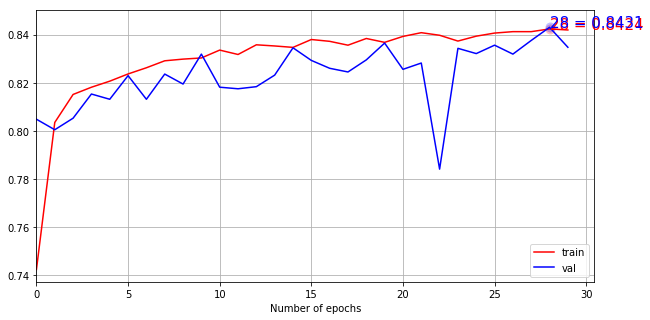

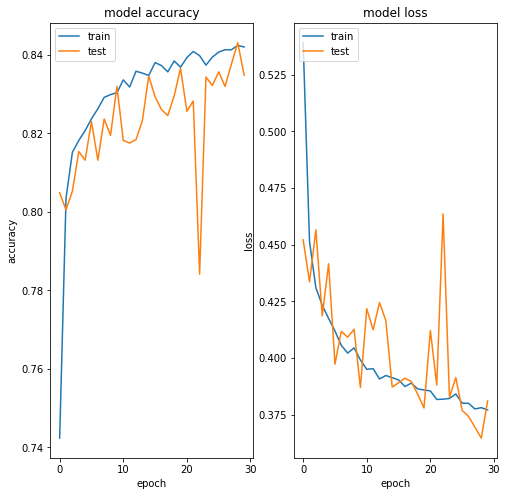


Epoch: 28 , Accuracy: 0.8430944


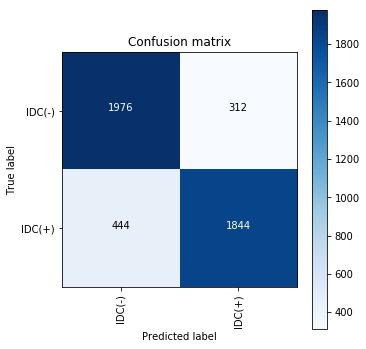

In [104]:
def runKerasCNNAugment_3(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data =(c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment_3(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Activation function: ELU

Epoch 1/30
583/583 [==============================] - 28s 49ms/step - loss: 0.9003 - acc: 0.7132 - val_loss: 0.4676 - val_acc: 0.7968
Epoch 2/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4822 - acc: 0.7830 - val_loss: 0.4519 - val_acc: 0.7994
Epoch 3/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4647 - acc: 0.7953 - val_loss: 0.4625 - val_acc: 0.8035
Epoch 4/30
583/583 [==============================] - 29s 49ms/step - loss: 0.4528 - acc: 0.8012 - val_loss: 0.4388 - val_acc: 0.8027
Epoch 5/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4487 - acc: 0.8039 - val_loss: 0.4316 - val_acc: 0.8090
Epoch 6/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4454 - acc: 0.8061 - val_loss: 0.4415 - val_acc: 0.8105
Epoch 7/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4346 - acc: 0.8115 - val_loss: 0.4201 - val_acc: 0.8123
Epoch 8/30
583/583 [==============================] - 28s 47ms

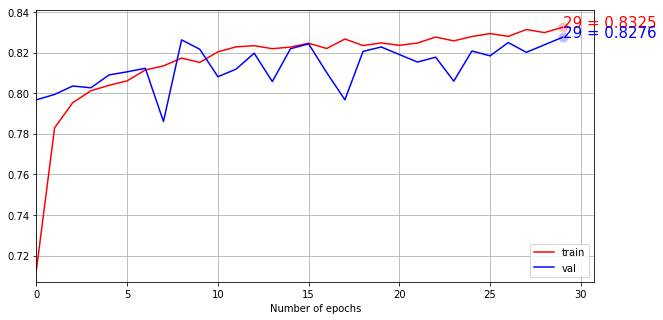

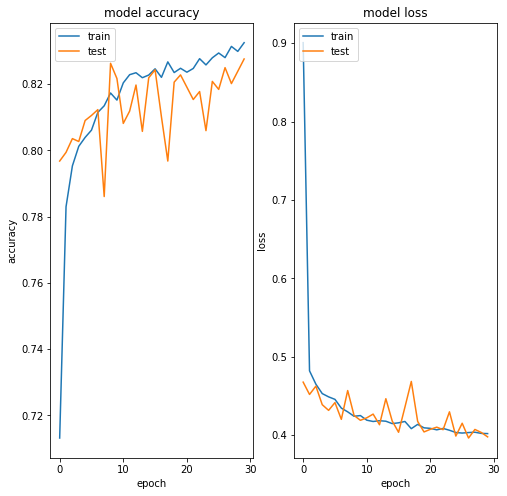


Epoch: 26 , Accuracy: 0.8249563


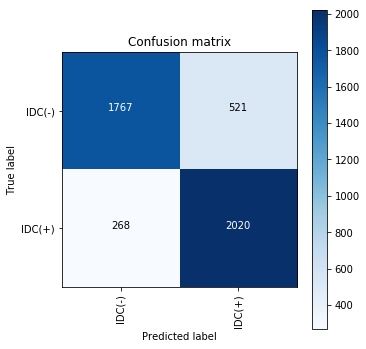

In [105]:
def runKerasCNNAugment_4(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.ELU(alpha=1.0),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.ELU(alpha=1.0)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.ELU(alpha=1.0)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment_4(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Activation function: selu

Epoch 1/30
583/583 [==============================] - 35s 60ms/step - loss: 2.7361 - acc: 0.6671 - val_loss: 0.6005 - val_acc: 0.7472
Epoch 2/30
583/583 [==============================] - 35s 59ms/step - loss: 0.4889 - acc: 0.7822 - val_loss: 0.6019 - val_acc: 0.6667
Epoch 3/30
583/583 [==============================] - 35s 61ms/step - loss: 0.4671 - acc: 0.7950 - val_loss: 0.4517 - val_acc: 0.7926
Epoch 4/30
583/583 [==============================] - 35s 60ms/step - loss: 0.4544 - acc: 0.8010 - val_loss: 0.4847 - val_acc: 0.7904
Epoch 5/30
583/583 [==============================] - 35s 61ms/step - loss: 0.4510 - acc: 0.8019 - val_loss: 0.5056 - val_acc: 0.7745
Epoch 6/30
583/583 [==============================] - 35s 61ms/step - loss: 0.4454 - acc: 0.8065 - val_loss: 0.4384 - val_acc: 0.8020
Epoch 7/30
583/583 [==============================] - 34s 58ms/step - loss: 0.4409 - acc: 0.8086 - val_loss: 0.4606 - val_acc: 0.8092
Epoch 8/30
583/583 [==============================] - 35s 59ms

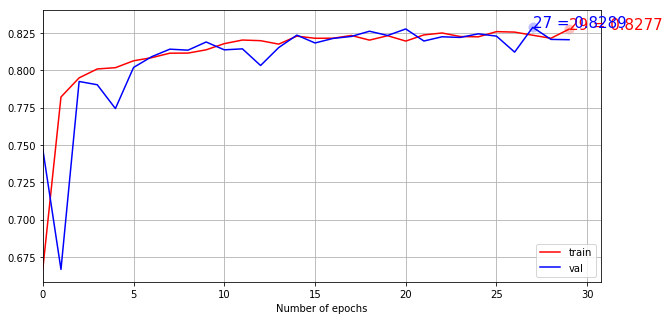

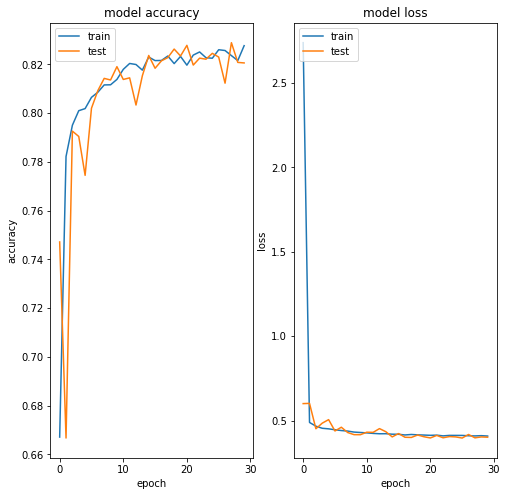


Epoch: 25 , Accuracy: 0.8229895


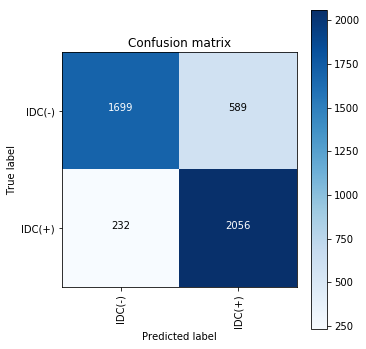

In [106]:
def runKerasCNNAugment_5(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='selu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='selu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='selu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment_5(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Activation function: softplus

Epoch 1/30
583/583 [==============================] - 30s 52ms/step - loss: 0.6674 - acc: 0.6552 - val_loss: 0.5356 - val_acc: 0.7247
Epoch 2/30
583/583 [==============================] - 30s 51ms/step - loss: 0.5289 - acc: 0.7459 - val_loss: 0.4808 - val_acc: 0.7773
Epoch 3/30
583/583 [==============================] - 30s 51ms/step - loss: 0.4862 - acc: 0.7756 - val_loss: 0.4635 - val_acc: 0.7963
Epoch 4/30
583/583 [==============================] - 30s 51ms/step - loss: 0.4616 - acc: 0.7901 - val_loss: 0.4731 - val_acc: 0.7677
Epoch 5/30
583/583 [==============================] - 30s 51ms/step - loss: 0.4565 - acc: 0.7925 - val_loss: 0.4399 - val_acc: 0.7955
Epoch 6/30
583/583 [==============================] - 30s 51ms/step - loss: 0.4476 - acc: 0.7946 - val_loss: 0.4405 - val_acc: 0.8038
Epoch 7/30
583/583 [==============================] - 30s 52ms/step - loss: 0.4485 - acc: 0.7994 - val_loss: 0.4619 - val_acc: 0.7740
Epoch 8/30
583/583 [==============================] - 30s 52ms

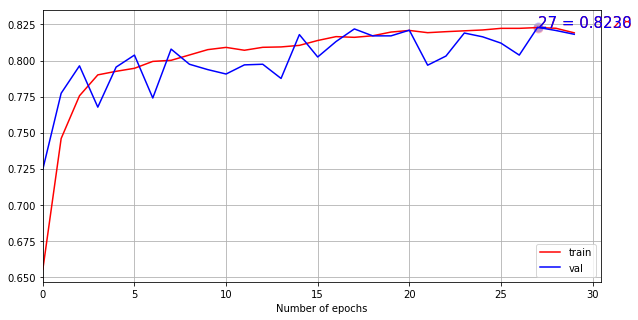

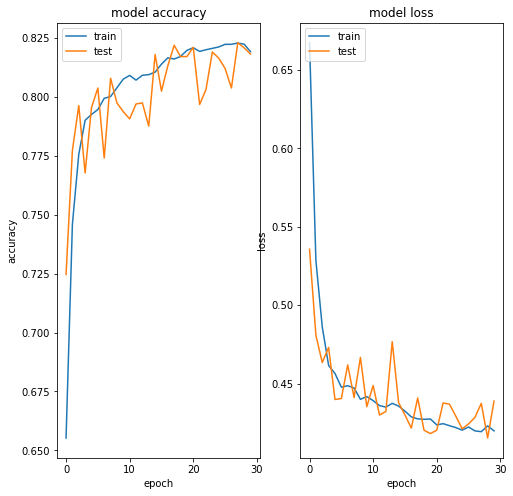


Epoch: 28 , Accuracy: 0.8208042


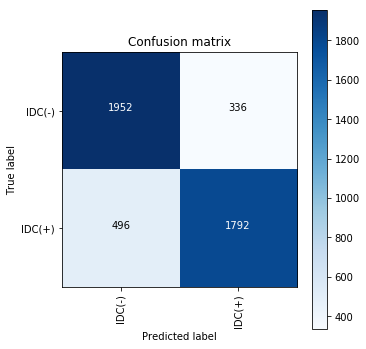

In [107]:
def runKerasCNNAugment_6(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='softplus',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='softplus'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='softplus'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment_6(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Activation function: softsign

Epoch 1/30
583/583 [==============================] - 30s 51ms/step - loss: 0.5651 - acc: 0.7263 - val_loss: 0.5080 - val_acc: 0.7611
Epoch 2/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4662 - acc: 0.7914 - val_loss: 0.5317 - val_acc: 0.7655
Epoch 3/30
583/583 [==============================] - 28s 48ms/step - loss: 0.4503 - acc: 0.7997 - val_loss: 0.4407 - val_acc: 0.8053
Epoch 4/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4431 - acc: 0.8052 - val_loss: 0.4491 - val_acc: 0.8077
Epoch 5/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4377 - acc: 0.8081 - val_loss: 0.4282 - val_acc: 0.8099
Epoch 6/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4337 - acc: 0.8116 - val_loss: 0.4440 - val_acc: 0.8118
Epoch 7/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4262 - acc: 0.8152 - val_loss: 0.5602 - val_acc: 0.7096
Epoch 8/30
583/583 [==============================] - 30s 51ms

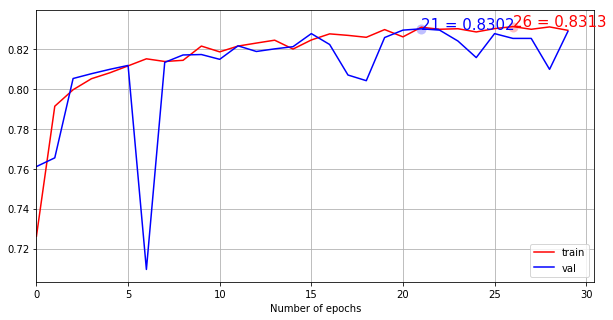

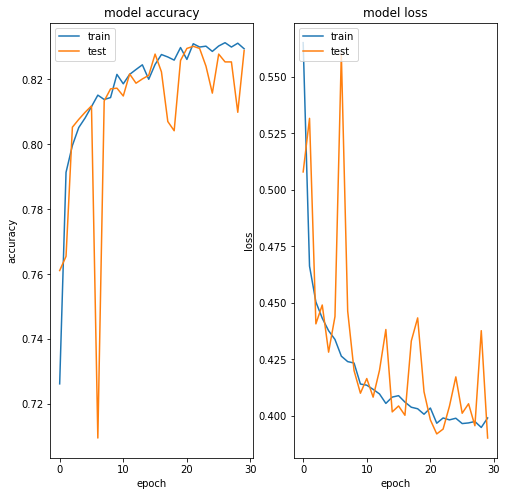


Epoch: 29 , Accuracy: 0.82888985


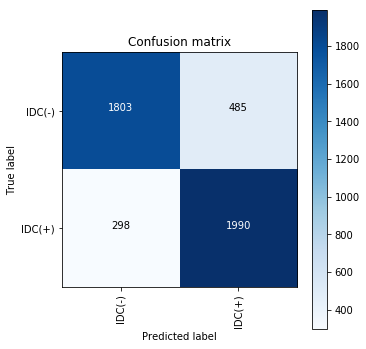

In [108]:
def runKerasCNNAugment_7(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='softsign',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='softsign'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='softsign'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment_7(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Activation function: exponential

Epoch 1/30
583/583 [==============================] - 28s 48ms/step - loss: 8.0618 - acc: 0.4996 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/30
583/583 [==============================] - 28s 48ms/step - loss: 8.0632 - acc: 0.4999 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/30
583/583 [==============================] - 27s 47ms/step - loss: 8.0593 - acc: 0.5001 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/30
583/583 [==============================] - 28s 48ms/step - loss: 8.0582 - acc: 0.5001 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/30
583/583 [==============================] - 28s 48ms/step - loss: 8.0630 - acc: 0.4999 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/30
583/583 [==============================] - 28s 47ms/step - loss: 8.0630 - acc: 0.4999 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/30
583/583 [==============================] - 28s 48ms/step - loss: 8.0630 - acc: 0.4999 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/30
583/583 [==============================] - 28s 49ms

D:\anacondaa\envs\python3.5\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


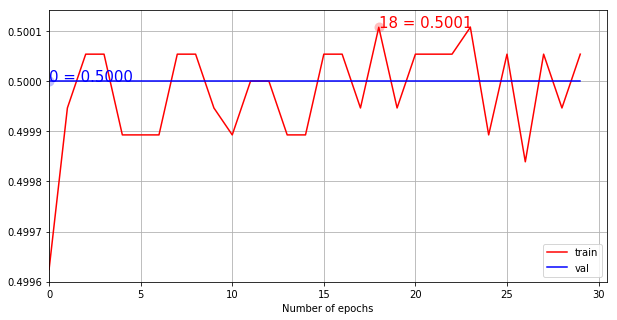

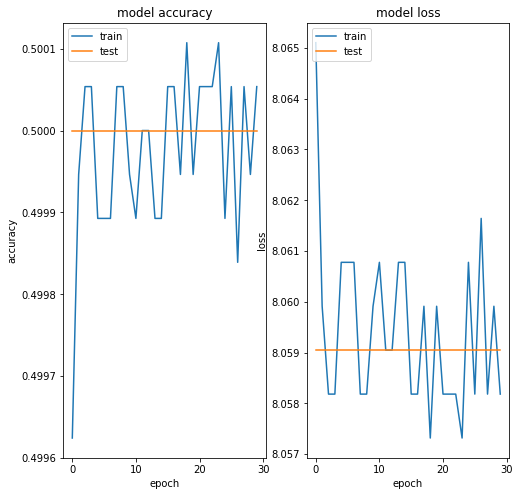


Epoch: 0 , Accuracy: 0.5


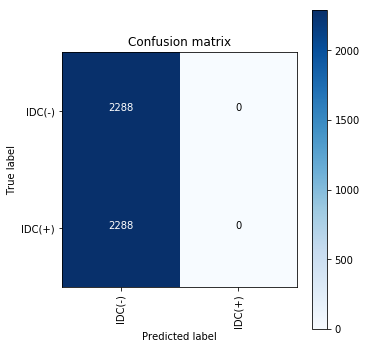

In [109]:
def runKerasCNNAugment_8(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='exponential',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='exponential'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='exponential'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment_8(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Rectified linear unit (ReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.38%</td>
        <td>7</td>
        <td>The best activation function for the model</td>
    </tr>
    <tr>
        <td>tanh</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.95%</td>
        <td>10</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Leaky rectified linear unit (Leaky ReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>83.92</td>
        <td>6</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.31%</td>
        <td>6</td>
        <td>It makes model reach the network plateaus quicker, but a little decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Exponential linear unit (ELU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.76%</td>
        <td>10</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>  
    <tr>
        <td>Scaled exponential linear unit (SELU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.89%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
     <tr>
        <td>Softplus</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.30%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
     <tr>
        <td>softsign</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>83.02%</td>
        <td>10</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
     <tr>
        <td>exponential</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>50%</td>
        <td></td>
        <td>Not learning, not suitable for the model</td>
    </tr>
</table>

I don't find any law now.

<h2>Part C</h2>
- Cost function

Change the activation function (use at least two). How does it effect the accuracy?<br/>
How does it effect how quickly the network plateaus?

In Part C, I will change the cost function which is the only parameter I will change and compare them how to effect the accuracy and how quickly the wetwork plateaus.

Cost function: mean_squared_error

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
583/583 [==============================] - 36s 61ms/step - loss: 0.1853 - acc: 0.7249 - val_loss: 0.1664 - val_acc: 0.7585
Epoch 2/30
583/583 [==============================] - 37s 63ms/step - loss: 0.1419 - acc: 0.8059 - val_loss: 0.1337 - val_acc: 0.8129
Epoch 3/30
583/583 [==============================] - 37s 63ms/step - loss: 0.1356 - acc: 0.8133 - val_loss: 0.1331 - val_acc: 0.8149
Epoch 4/30
583/583 [==============================] - 35s 61ms/step - loss: 0.1320 - acc: 0.8191 - val_loss: 0.1358 - val_acc: 0.8086
Epoch 5/30
583/583 [==============================] - 38s 64ms/step - loss: 0.1308 - acc: 0.8195 - val_loss: 0.1281 - val_acc: 0.8258
Epoch 6/30
583/583 [==============================] - 37s 63ms/step - loss: 0.1289 - acc: 0.8244 - val_loss: 0.1276 - val_acc: 0.8188
Epoch 7/30
583/583 [==============================] - 37s 63ms/step - loss: 0.1274 - acc: 0.8292 - val_loss: 0.1243 - val_acc: 0.8300
Epoch 8/30
583

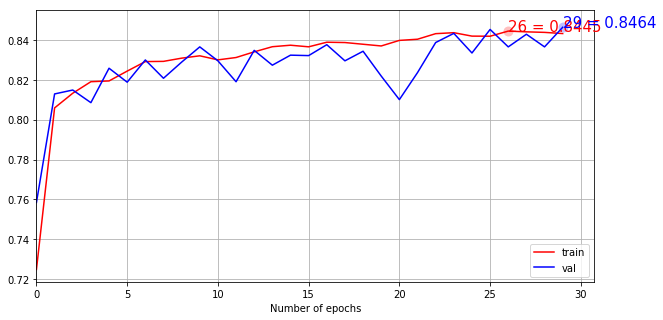

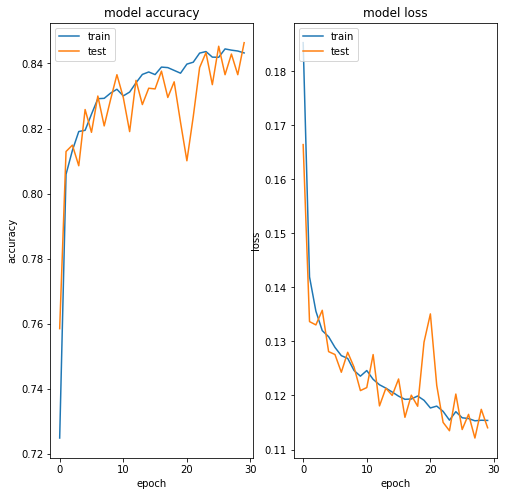


Epoch: 27 , Accuracy: 0.8428759


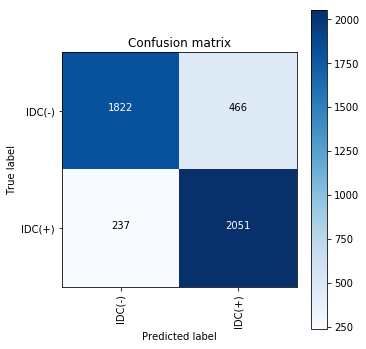

In [110]:
def runKerasCNN_1(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data =(c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_1(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Cost function: hinge

Epoch 1/30
583/583 [==============================] - 37s 64ms/step - loss: 0.6542 - acc: 0.6941 - val_loss: 0.6237 - val_acc: 0.7550
Epoch 2/30
583/583 [==============================] - 37s 63ms/step - loss: 0.6054 - acc: 0.7897 - val_loss: 0.6152 - val_acc: 0.7681
Epoch 3/30
583/583 [==============================] - 37s 63ms/step - loss: 0.5996 - acc: 0.8022 - val_loss: 0.6023 - val_acc: 0.7961
Epoch 4/30
583/583 [==============================] - 37s 64ms/step - loss: 0.6001 - acc: 0.8001 - val_loss: 0.5978 - val_acc: 0.8042
Epoch 5/30
583/583 [==============================] - 37s 63ms/step - loss: 0.6001 - acc: 0.7995 - val_loss: 0.6774 - val_acc: 0.6434
Epoch 6/30
583/583 [==============================] - 37s 63ms/step - loss: 0.6002 - acc: 0.7994 - val_loss: 0.5999 - val_acc: 0.8014
Epoch 7/30
583/583 [==============================] - 37s 63ms/step - loss: 0.5976 - acc: 0.8055 - val_loss: 0.5979 - val_acc: 0.8046
Epoch 8/30
583/583 [==============================] - 36s 63ms

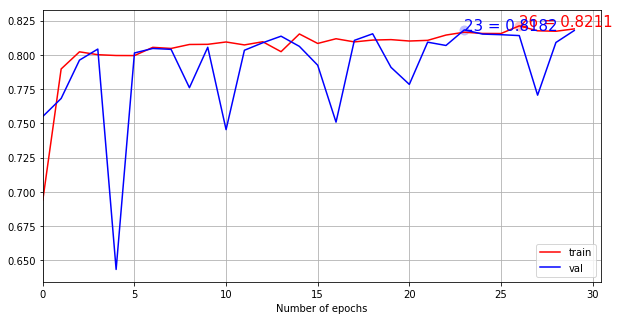

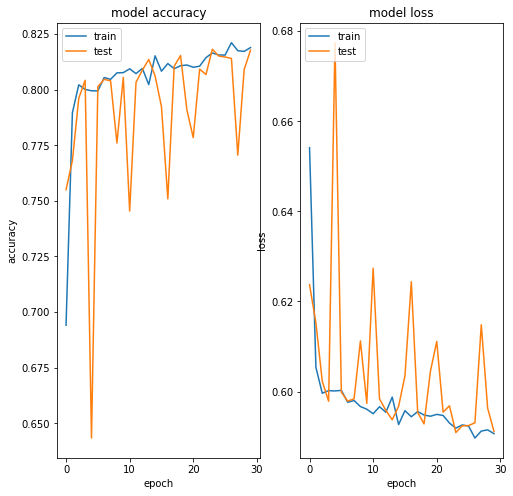


Epoch: 23 , Accuracy: 0.8181818


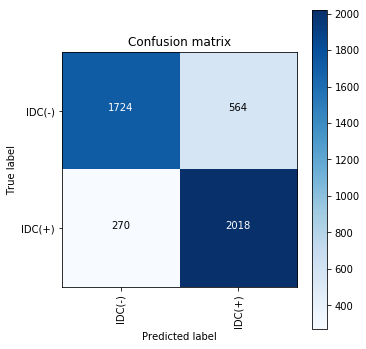

In [111]:
def runKerasCNN_2(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='hinge',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_2(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Cost function: kullback_leibler_divergence

Epoch 1/30
583/583 [==============================] - 37s 64ms/step - loss: 0.5429 - acc: 0.7299 - val_loss: 0.4761 - val_acc: 0.7753
Epoch 2/30
583/583 [==============================] - 37s 63ms/step - loss: 0.4504 - acc: 0.8057 - val_loss: 0.4229 - val_acc: 0.8151
Epoch 3/30
583/583 [==============================] - 37s 63ms/step - loss: 0.4367 - acc: 0.8134 - val_loss: 0.4092 - val_acc: 0.8204
Epoch 4/30
583/583 [==============================] - 37s 63ms/step - loss: 0.4248 - acc: 0.8189 - val_loss: 0.4127 - val_acc: 0.8210
Epoch 5/30
583/583 [==============================] - 37s 63ms/step - loss: 0.4183 - acc: 0.8199 - val_loss: 0.4042 - val_acc: 0.8188
Epoch 6/30
583/583 [==============================] - 37s 63ms/step - loss: 0.4109 - acc: 0.8240 - val_loss: 0.5301 - val_acc: 0.7273
Epoch 7/30
583/583 [==============================] - 37s 63ms/step - loss: 0.4084 - acc: 0.8265 - val_loss: 0.4580 - val_acc: 0.8022
Epoch 8/30
583/583 [==============================] - 37s 63ms

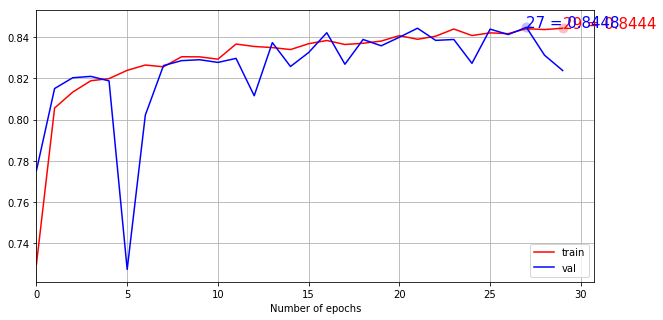

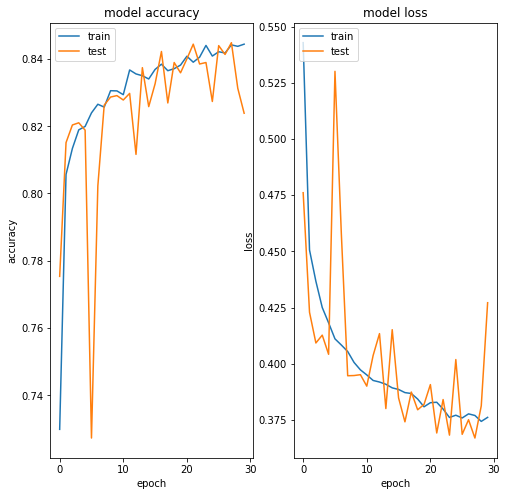


Epoch: 27 , Accuracy: 0.8448427


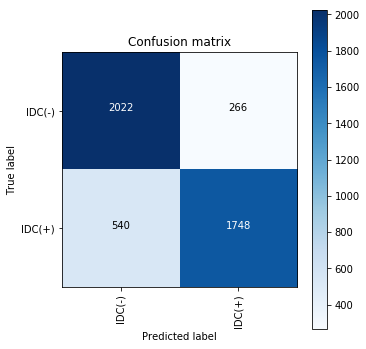

In [112]:
def runKerasCNN_3(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='kullback_leibler_divergence',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_3(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Cost function: cosine_proximity

Epoch 1/30
583/583 [==============================] - 39s 67ms/step - loss: -0.7889 - acc: 0.7199 - val_loss: -0.8449 - val_acc: 0.8064
Epoch 2/30
583/583 [==============================] - 37s 63ms/step - loss: -0.8436 - acc: 0.8057 - val_loss: -0.8490 - val_acc: 0.8114
Epoch 3/30
583/583 [==============================] - 37s 63ms/step - loss: -0.8505 - acc: 0.8117 - val_loss: -0.8390 - val_acc: 0.7976
Epoch 4/30
583/583 [==============================] - 37s 64ms/step - loss: -0.8524 - acc: 0.8173 - val_loss: -0.8408 - val_acc: 0.8009
Epoch 5/30
583/583 [==============================] - 37s 64ms/step - loss: -0.8542 - acc: 0.8213 - val_loss: -0.8406 - val_acc: 0.7981
Epoch 6/30
583/583 [==============================] - 37s 63ms/step - loss: -0.8581 - acc: 0.8255 - val_loss: -0.8578 - val_acc: 0.8228
Epoch 7/30
583/583 [==============================] - 37s 64ms/step - loss: -0.8605 - acc: 0.8277 - val_loss: -0.8626 - val_acc: 0.8285
Epoch 8/30
583/583 [============================

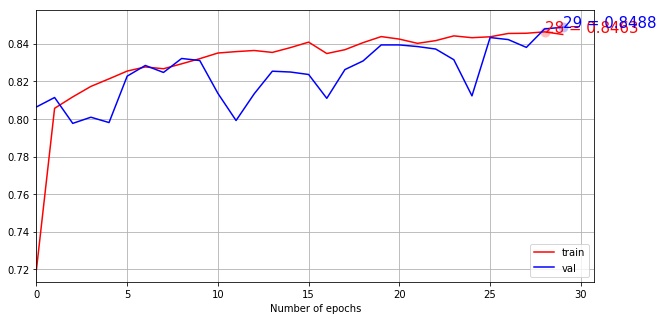

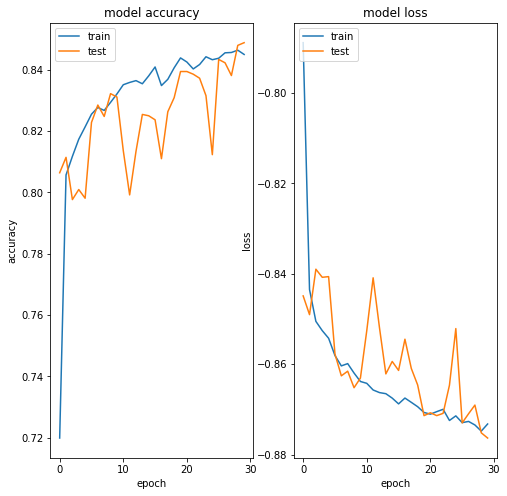


Epoch: 29 , Accuracy: 0.8487762


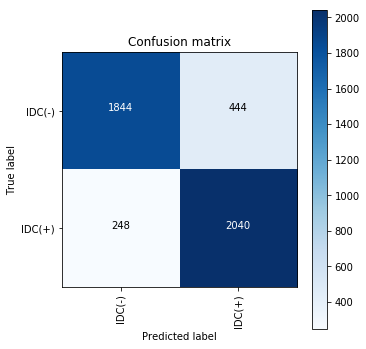

In [113]:
def runKerasCNN_4(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='cosine_proximity',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_4(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Cost function: binary_crossentropy

Epoch 1/30
583/583 [==============================] - 38s 65ms/step - loss: 0.5608 - acc: 0.7228 - val_loss: 0.4553 - val_acc: 0.7928
Epoch 2/30
583/583 [==============================] - 37s 64ms/step - loss: 0.4595 - acc: 0.7987 - val_loss: 0.4209 - val_acc: 0.8149
Epoch 3/30
583/583 [==============================] - 37s 64ms/step - loss: 0.4426 - acc: 0.8079 - val_loss: 0.4175 - val_acc: 0.8142
Epoch 4/30
583/583 [==============================] - 37s 64ms/step - loss: 0.4318 - acc: 0.8107 - val_loss: 0.4445 - val_acc: 0.8068
Epoch 5/30
583/583 [==============================] - 37s 64ms/step - loss: 0.4199 - acc: 0.8213 - val_loss: 0.4072 - val_acc: 0.8167
Epoch 6/30
583/583 [==============================] - 37s 64ms/step - loss: 0.4152 - acc: 0.8237 - val_loss: 0.4088 - val_acc: 0.8188
Epoch 7/30
583/583 [==============================] - 37s 64ms/step - loss: 0.4091 - acc: 0.8230 - val_loss: 0.4156 - val_acc: 0.8014
Epoch 8/30
583/583 [==============================] - 37s 64ms

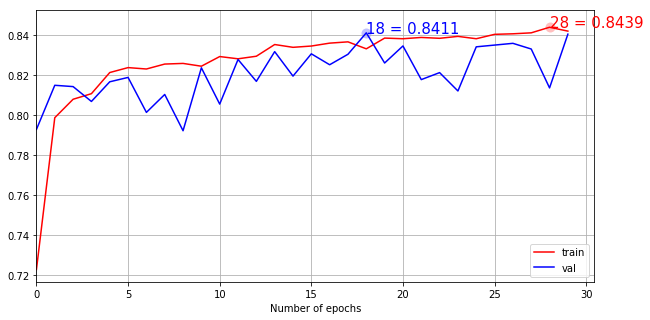

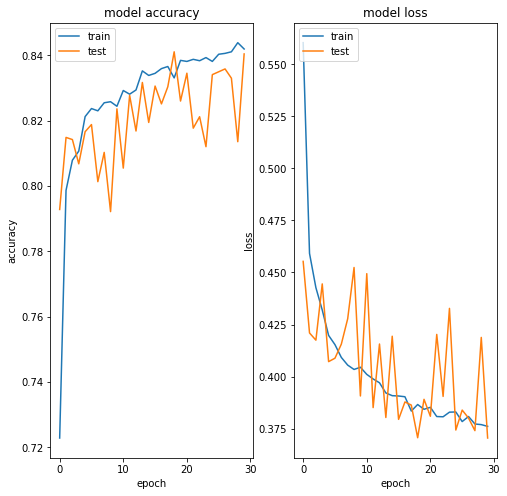


Epoch: 29 , Accuracy: 0.84047204


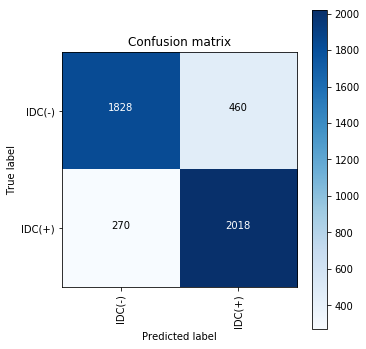

In [114]:
def runKerasCNN_5(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_5(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.31%</td>
        <td>6</td>
        <td>Contrast model</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td>It makes model reach the network plateaus quicker, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>hinge</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>81.82%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>kullback_leibler_divergence</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.48%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus quicker, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>cosine_proximity </td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.88%</td>
        <td>1</td>
        <td>It makes model reach the network plateaus quicker, and increase the accuracy which is best model.</td>
    </tr>  
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>binary_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.11%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
     <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.30%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
</table>

The several cost functions all have almost the same accuracy which is about 84%. categorical_crossentropy, mean_squared_error, kullback_leibler_divergence, cosine_proximity, and binary_crossentropy are all suitable for the model.

<h2>Part D</h2>
- Epochs

How does it effect the accuracy?<br/>
How quickly does the network plateau?

I will change the epochs up to 200 and see is there any changes.

Epoch 1/200
583/583 [==============================] - 38s 65ms/step - loss: 0.1885 - acc: 0.7178 - val_loss: 0.1406 - val_acc: 0.8051
Epoch 2/200
583/583 [==============================] - 37s 63ms/step - loss: 0.1435 - acc: 0.8028 - val_loss: 0.1357 - val_acc: 0.8110
Epoch 3/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1385 - acc: 0.8087 - val_loss: 0.1422 - val_acc: 0.8046
Epoch 4/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1353 - acc: 0.8128 - val_loss: 0.1323 - val_acc: 0.8158
Epoch 5/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1335 - acc: 0.8169 - val_loss: 0.1287 - val_acc: 0.8201
Epoch 6/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1291 - acc: 0.8231 - val_loss: 0.1358 - val_acc: 0.8108
Epoch 7/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1282 - acc: 0.8246 - val_loss: 0.1272 - val_acc: 0.8256
Epoch 8/200
583/583 [==============================] - 

583/583 [==============================] - 37s 64ms/step - loss: 0.1063 - acc: 0.8578 - val_loss: 0.1036 - val_acc: 0.8588
Epoch 74/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1060 - acc: 0.8581 - val_loss: 0.1054 - val_acc: 0.8595
Epoch 75/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1059 - acc: 0.8582 - val_loss: 0.1130 - val_acc: 0.8433
Epoch 76/200
583/583 [==============================] - 37s 63ms/step - loss: 0.1060 - acc: 0.8572 - val_loss: 0.1072 - val_acc: 0.8569
Epoch 77/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1063 - acc: 0.8570 - val_loss: 0.1068 - val_acc: 0.8538
Epoch 78/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1060 - acc: 0.8573 - val_loss: 0.1056 - val_acc: 0.8608
Epoch 79/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1061 - acc: 0.8597 - val_loss: 0.1161 - val_acc: 0.8435
Epoch 80/200
583/583 [==============================] - 37s 6

Epoch 145/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1009 - acc: 0.8646 - val_loss: 0.0994 - val_acc: 0.8634
Epoch 146/200
583/583 [==============================] - 35s 61ms/step - loss: 0.0997 - acc: 0.8679 - val_loss: 0.1013 - val_acc: 0.8652
Epoch 147/200
583/583 [==============================] - 35s 60ms/step - loss: 0.1012 - acc: 0.8644 - val_loss: 0.0983 - val_acc: 0.8684
Epoch 148/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1011 - acc: 0.8662 - val_loss: 0.1018 - val_acc: 0.8652
Epoch 149/200
583/583 [==============================] - 37s 64ms/step - loss: 0.1010 - acc: 0.8636 - val_loss: 0.0970 - val_acc: 0.8695
Epoch 150/200
583/583 [==============================] - 37s 64ms/step - loss: 0.0995 - acc: 0.8687 - val_loss: 0.1016 - val_acc: 0.8656
Epoch 151/200
583/583 [==============================] - 38s 65ms/step - loss: 0.0994 - acc: 0.8688 - val_loss: 0.1081 - val_acc: 0.8562
Epoch 152/200
583/583 [==================

Epoch 181/200
583/583 [==============================] - 37s 64ms/step - loss: 0.0978 - acc: 0.8705 - val_loss: 0.1021 - val_acc: 0.8606
Epoch 182/200
583/583 [==============================] - 37s 64ms/step - loss: 0.0972 - acc: 0.8681 - val_loss: 0.0999 - val_acc: 0.8680
Epoch 183/200
583/583 [==============================] - 37s 64ms/step - loss: 0.0981 - acc: 0.8699 - val_loss: 0.0981 - val_acc: 0.8700
Epoch 184/200
583/583 [==============================] - 38s 64ms/step - loss: 0.0989 - acc: 0.8683 - val_loss: 0.0980 - val_acc: 0.8687
Epoch 185/200
583/583 [==============================] - 38s 64ms/step - loss: 0.0985 - acc: 0.8703 - val_loss: 0.0972 - val_acc: 0.8660
Epoch 186/200
583/583 [==============================] - 37s 64ms/step - loss: 0.0978 - acc: 0.8697 - val_loss: 0.1006 - val_acc: 0.8698
Epoch 187/200
583/583 [==============================] - 38s 65ms/step - loss: 0.0985 - acc: 0.8688 - val_loss: 0.1019 - val_acc: 0.8665
Epoch 188/200
583/583 [==================

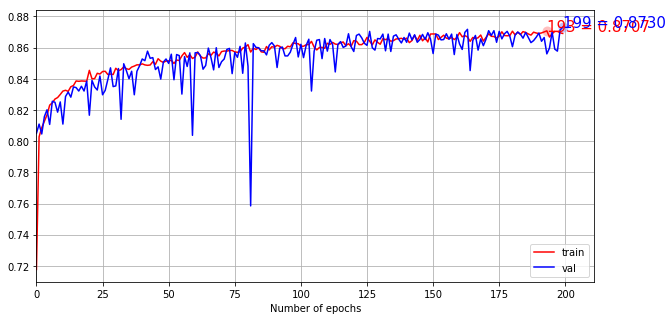

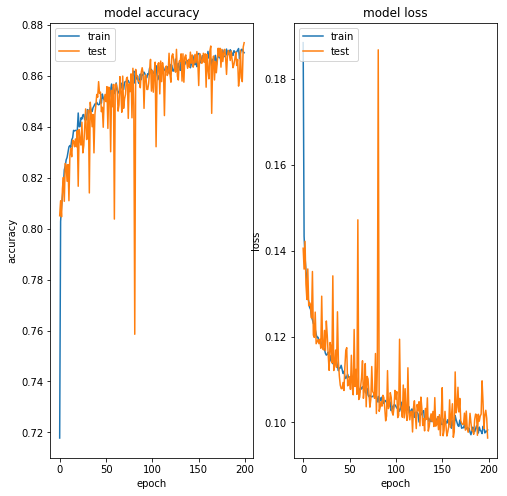


Epoch: 199 , Accuracy: 0.8730332


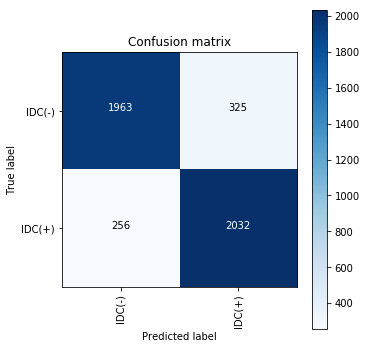

In [115]:
def runKerasCNN_11(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 200
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_11(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td></td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>200</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>87.30%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
</table>

Through adding the epochs, we can find that the accuracy is still increasing and it seems to have not reached the highest yet. In addition, the loss is still decreasing. I don't know why it has not reached a completely stable state. I guess it is related to my model structure. My model is simple and has few parameters and my trainuing data is enough which causes the model to not easily overfit. In the later stages of training, accuracy is still growing. I guess thereason is that the model is already familiar with the training data and validation data.

<h2>Part E</h2>
- Gradient estimation

How does it effect the accuracy?<br/>
How does it effect how quickly the network plateaus?

Gradient descent is one of the most popular algorithms to perform optimization and by far the most common way to optimize neural networks. At the same time, every state-of-the-art Deep Learning library contains implementations of various algorithms to optimize gradient descent (e.g. lasagne's, caffe's, and keras' documentation). These algorithms, however, are often used as black-box optimizers, as practical explanations of their strengths and weaknesses are hard to come by.

You can see the following link to understand more about gradient estimation.<br/>
http://ruder.io/optimizing-gradient-descent/

In Part E, I will change the gradient estimation which is the only parameter I will change and compare them how to effect the accuracy and how quickly the wetwork plateaus.

optimizer: Stochastic Gradient Descent

Epoch 1/30
583/583 [==============================] - 33s 57ms/step - loss: 0.2031 - acc: 0.6848 - val_loss: 0.1488 - val_acc: 0.7839
Epoch 2/30
583/583 [==============================] - 33s 56ms/step - loss: 0.1578 - acc: 0.7801 - val_loss: 0.1436 - val_acc: 0.8073
Epoch 3/30
583/583 [==============================] - 33s 57ms/step - loss: 0.1493 - acc: 0.7923 - val_loss: 0.1489 - val_acc: 0.8009
Epoch 4/30
583/583 [==============================] - 33s 56ms/step - loss: 0.1431 - acc: 0.8019 - val_loss: 0.1522 - val_acc: 0.7780
Epoch 5/30
583/583 [==============================] - 33s 57ms/step - loss: 0.1395 - acc: 0.8088 - val_loss: 0.1405 - val_acc: 0.7979
Epoch 6/30
583/583 [==============================] - 33s 56ms/step - loss: 0.1387 - acc: 0.8096 - val_loss: 0.1528 - val_acc: 0.7788
Epoch 7/30
583/583 [==============================] - 33s 57ms/step - loss: 0.1377 - acc: 0.8102 - val_loss: 0.1428 - val_acc: 0.7950
Epoch 8/30
583/583 [==============================] - 33s 57ms

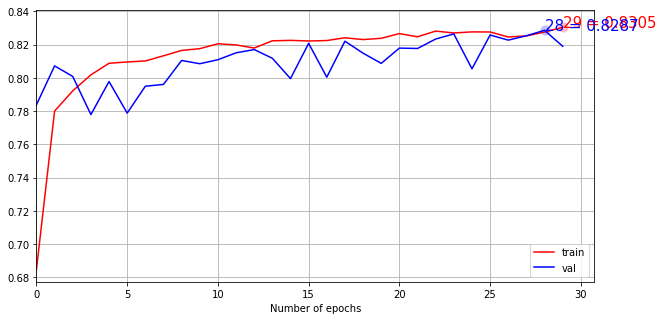

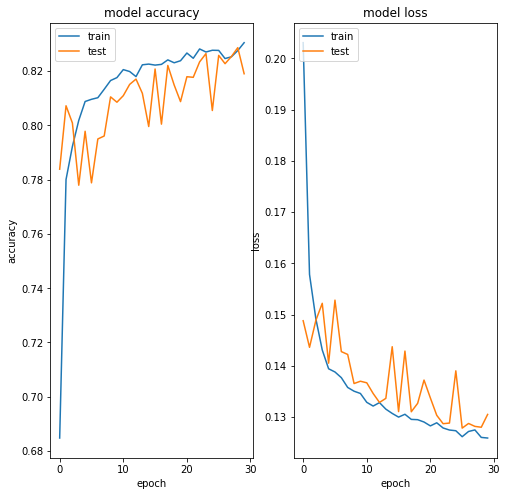


Epoch: 25 , Accuracy: 0.8258304


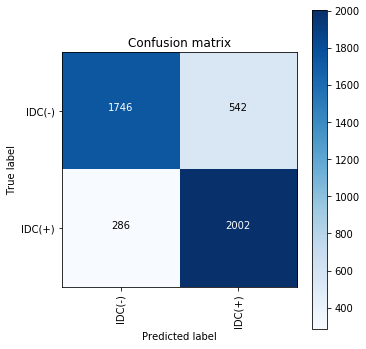

In [117]:
def runKerasCNN1(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer='SGD',
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data =(c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN1(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

optimizer: Adagrad

Epoch 1/30
583/583 [==============================] - 36s 61ms/step - loss: 0.2704 - acc: 0.6622 - val_loss: 0.1425 - val_acc: 0.8068
Epoch 2/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1384 - acc: 0.8121 - val_loss: 0.1338 - val_acc: 0.8164
Epoch 3/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1315 - acc: 0.8239 - val_loss: 0.1891 - val_acc: 0.7109
Epoch 4/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1292 - acc: 0.8259 - val_loss: 0.1276 - val_acc: 0.8276
Epoch 5/30
583/583 [==============================] - 36s 61ms/step - loss: 0.1272 - acc: 0.8268 - val_loss: 0.1294 - val_acc: 0.8230
Epoch 6/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1251 - acc: 0.8299 - val_loss: 0.1294 - val_acc: 0.8232
Epoch 7/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1238 - acc: 0.8306 - val_loss: 0.1285 - val_acc: 0.8234
Epoch 8/30
583/583 [==============================] - 34s 59ms

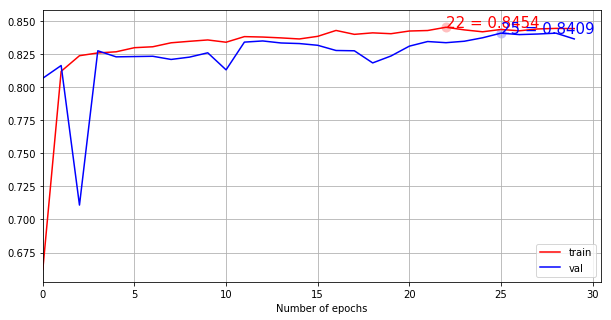

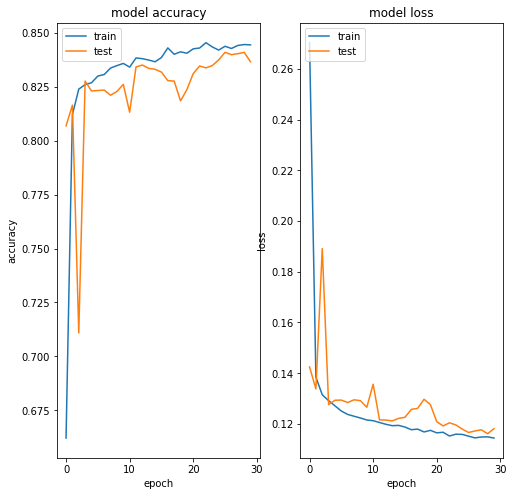


Epoch: 28 , Accuracy: 0.84090906


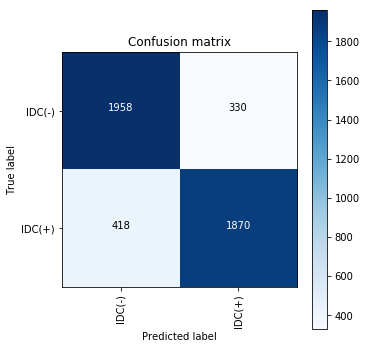

In [118]:
def runKerasCNN2(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer='Adagrad',
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data =(c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN2(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

optimizer: RMSprop

Epoch 1/30
583/583 [==============================] - 36s 62ms/step - loss: 0.1755 - acc: 0.7521 - val_loss: 0.1379 - val_acc: 0.8086
Epoch 2/30
583/583 [==============================] - 36s 62ms/step - loss: 0.1461 - acc: 0.7986 - val_loss: 0.1316 - val_acc: 0.8186
Epoch 3/30
583/583 [==============================] - 36s 63ms/step - loss: 0.1410 - acc: 0.8046 - val_loss: 0.1364 - val_acc: 0.8171
Epoch 4/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1386 - acc: 0.8116 - val_loss: 0.1355 - val_acc: 0.8075
Epoch 5/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1337 - acc: 0.8183 - val_loss: 0.1276 - val_acc: 0.8256
Epoch 6/30
583/583 [==============================] - 36s 62ms/step - loss: 0.1335 - acc: 0.8193 - val_loss: 0.1313 - val_acc: 0.8197
Epoch 7/30
583/583 [==============================] - 37s 63ms/step - loss: 0.1306 - acc: 0.8244 - val_loss: 0.1257 - val_acc: 0.8258
Epoch 8/30
583/583 [==============================] - 36s 62ms

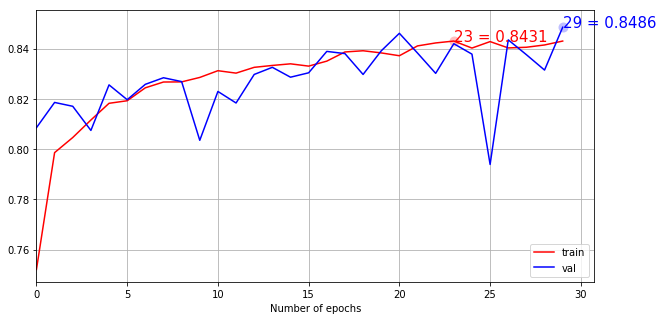

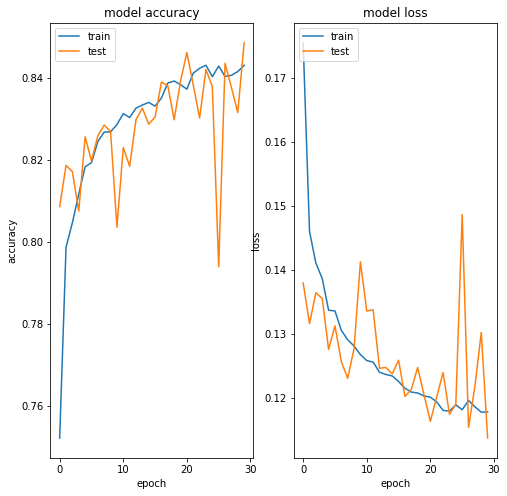


Epoch: 29 , Accuracy: 0.8485577


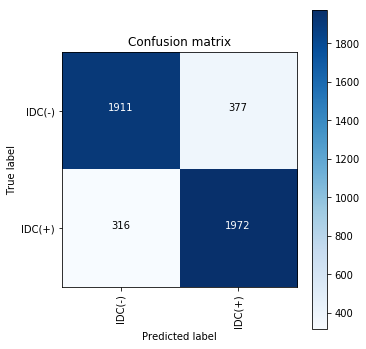

In [119]:
def runKerasCNN4(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer='RMSprop',
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN4(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

optimizer: Adam

Epoch 1/30
583/583 [==============================] - 37s 63ms/step - loss: 0.1603 - acc: 0.7715 - val_loss: 0.1545 - val_acc: 0.7714
Epoch 2/30
583/583 [==============================] - 36s 62ms/step - loss: 0.1403 - acc: 0.8049 - val_loss: 0.1360 - val_acc: 0.8136
Epoch 3/30
583/583 [==============================] - 37s 63ms/step - loss: 0.1377 - acc: 0.8106 - val_loss: 0.1545 - val_acc: 0.7705
Epoch 4/30
583/583 [==============================] - 37s 63ms/step - loss: 0.1354 - acc: 0.8135 - val_loss: 0.1353 - val_acc: 0.8055
Epoch 5/30
583/583 [==============================] - 37s 63ms/step - loss: 0.1331 - acc: 0.8185 - val_loss: 0.1329 - val_acc: 0.8162
Epoch 6/30
583/583 [==============================] - 38s 66ms/step - loss: 0.1327 - acc: 0.8193 - val_loss: 0.1305 - val_acc: 0.8204
Epoch 7/30
583/583 [==============================] - 36s 62ms/step - loss: 0.1306 - acc: 0.8230 - val_loss: 0.1278 - val_acc: 0.8241
Epoch 8/30
583/583 [==============================] - 37s 63ms

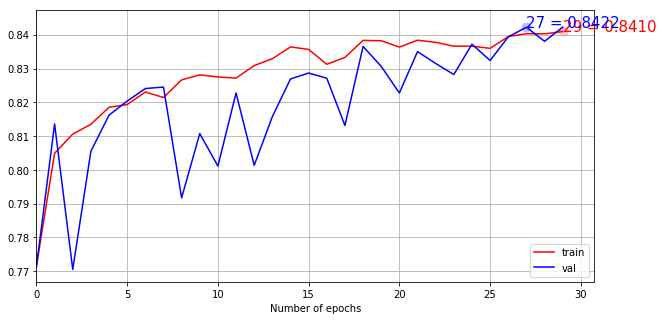

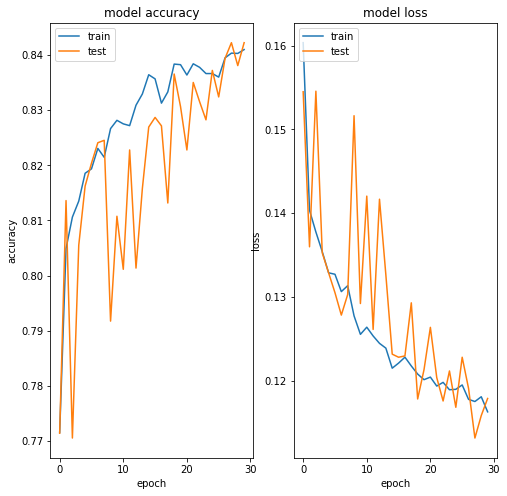


Epoch: 27 , Accuracy: 0.8422203


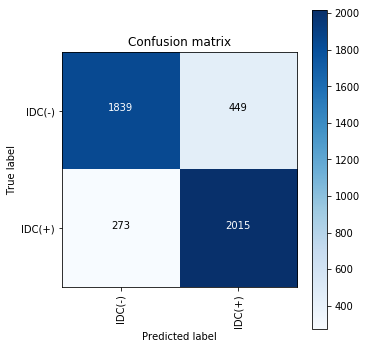

In [120]:
def runKerasCNN5(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer='Adam',
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN5(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

optimizer: Adamax

Epoch 1/30
583/583 [==============================] - 43s 74ms/step - loss: 0.1504 - acc: 0.7892 - val_loss: 0.1332 - val_acc: 0.8169
Epoch 2/30
583/583 [==============================] - 42s 72ms/step - loss: 0.1356 - acc: 0.8144 - val_loss: 0.1331 - val_acc: 0.8232
Epoch 3/30
583/583 [==============================] - 42s 72ms/step - loss: 0.1303 - acc: 0.8235 - val_loss: 0.1541 - val_acc: 0.7891
Epoch 4/30
583/583 [==============================] - 41s 71ms/step - loss: 0.1307 - acc: 0.8220 - val_loss: 0.1311 - val_acc: 0.8173
Epoch 5/30
583/583 [==============================] - 42s 72ms/step - loss: 0.1279 - acc: 0.8257 - val_loss: 0.1323 - val_acc: 0.8153
Epoch 6/30
583/583 [==============================] - 42s 72ms/step - loss: 0.1263 - acc: 0.8291 - val_loss: 0.1250 - val_acc: 0.8317
Epoch 7/30
583/583 [==============================] - 42s 72ms/step - loss: 0.1263 - acc: 0.8273 - val_loss: 0.1327 - val_acc: 0.8151
Epoch 8/30
583/583 [==============================] - 42s 72ms

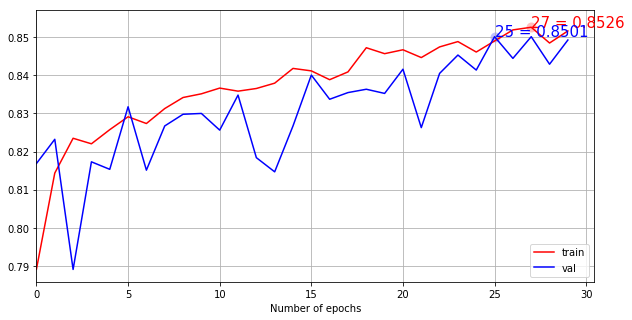

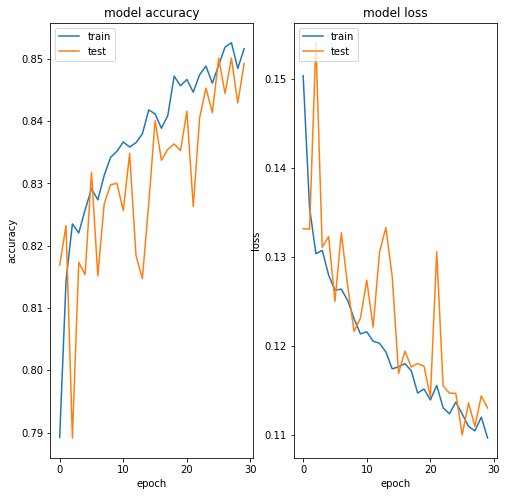


Epoch: 25 , Accuracy: 0.8500874


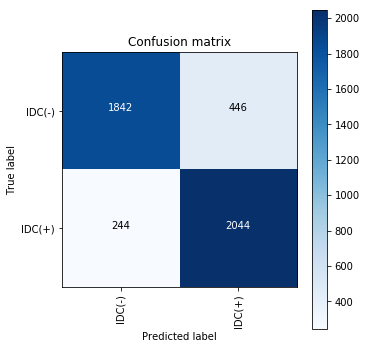

In [121]:
def runKerasCNN6(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer='Adamax',
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN6(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

optimizer: Nadm

Epoch 1/30
583/583 [==============================] - 33s 57ms/step - loss: 0.1703 - acc: 0.7545 - val_loss: 0.4213 - val_acc: 0.5000
Epoch 2/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1449 - acc: 0.8011 - val_loss: 0.1354 - val_acc: 0.8155
Epoch 3/30
583/583 [==============================] - 36s 61ms/step - loss: 0.1373 - acc: 0.8108 - val_loss: 0.1254 - val_acc: 0.8311
Epoch 4/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1359 - acc: 0.8118 - val_loss: 0.1251 - val_acc: 0.8326
Epoch 5/30
583/583 [==============================] - 35s 59ms/step - loss: 0.1322 - acc: 0.8184 - val_loss: 0.1264 - val_acc: 0.8236
Epoch 6/30
583/583 [==============================] - 35s 59ms/step - loss: 0.4265 - acc: 0.5641 - val_loss: 0.5013 - val_acc: 0.5000
Epoch 7/30
583/583 [==============================] - 35s 59ms/step - loss: 0.5000 - acc: 0.5000 - val_loss: 0.5013 - val_acc: 0.5000
Epoch 8/30
583/583 [==============================] - 34s 59ms

D:\anacondaa\envs\python3.5\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


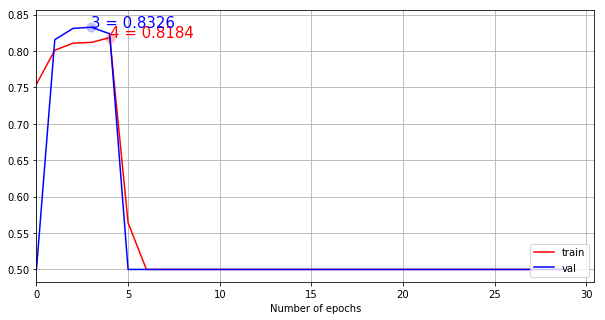

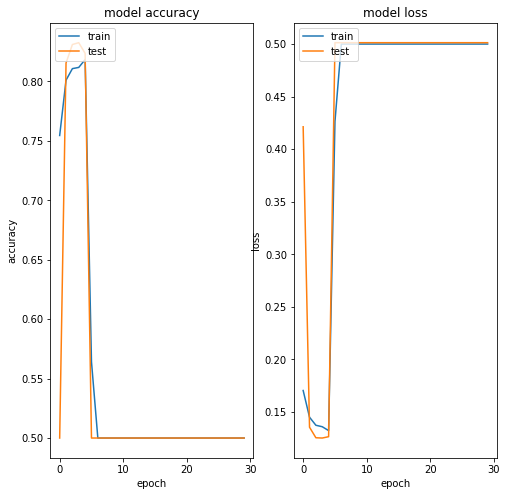


Epoch: 3 , Accuracy: 0.832603


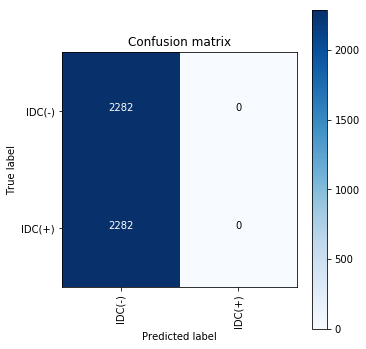

In [17]:
def runKerasCNN7(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer='Nadam',
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN7(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td></td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Stochastic Gradient Descent</td>
        <td>none</td>
        <td>82.87%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adagrad</td>
        <td>none</td>
        <td>84.09%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>RMSprop</td>
        <td>none</td>
        <td>84.86%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adam</td>
        <td>none</td>
        <td>84.22%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adamax</td>
        <td>none</td>
        <td>85.01%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy which is the best parameter</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Nadam</td>
        <td>none</td>
        <td>50%</td>
        <td></td>
        <td>It dones't learn</td>
    </tr>
</table>

Changing the gradient estimation seems have no effect on how quickly the network plateaus. But through looking the plot, I find if the loss plot has faster the rate of decline, it has the higher the correct rate.

<h2>Part F</h2>
- Network Architecture

How does it effect the accuracy?<br/>
How does it effect how quickly the network plateaus?

Convolution Layer

Convolution is the first layer to extract features from an input image. Convolution preserves the relationship between pixels by learning image features using small squares of input data. It is a mathematical operation that takes two inputs such as image matrix and a filter or kernal.

Strides

Stride is the number of pixels shifts over the input matrix. When the stride is 1 then we move the filters to 1 pixel at a time. When the stride is 2 then we move the filters to 2 pixels at a time and so on. The below figure shows convolution would work with a stride of 2.

Padding

Sometimes filter does not fit perfectly fit the input image. We have two options:

Pad the picture with zeros (zero-padding) so that it fits
Drop the part of the image where the filter did not fit. This is called valid padding which keeps only valid part of the image.

Pooling Layer

Pooling layers section would reduce the number of parameters when the images are too large. Spatial pooling also called subsampling or downsampling which reduces the dimensionality of each map but retains the important information. Spatial pooling can be of different types:

Max Pooling
Average Pooling
Sum Pooling
Max pooling take the largest element from the rectified feature map. Taking the largest element could also take the average pooling. Sum of all elements in the feature map call as sum pooling.

Fully Connected Layer

The layer we call as FC layer, we flattened our matrix into vector and feed it into a fully connected layer like neural network.

In the above diagram, feature map matrix will be converted as vector (x1, x2, x3, …). With the fully connected layers, we combined these features together to create a model. Finally, we have an activation function such as softmax or sigmoid to classify the outputs as cat, dog, car, truck etc.

In Part F, I will change the network architecture which is the only parameter I will change and compare them how to effect the accuracy and how quickly the wetwork plateaus.

3 convolution layer(32,64,128) -> maxpooling ->dense(256) with 2 dropout

Epoch 1/30
583/583 [==============================] - 70s 120ms/step - loss: 0.5674 - acc: 0.7141 - val_loss: 0.4353 - val_acc: 0.8138
Epoch 2/30
583/583 [==============================] - 70s 119ms/step - loss: 0.4632 - acc: 0.7976 - val_loss: 0.4243 - val_acc: 0.8144
Epoch 3/30
583/583 [==============================] - 70s 119ms/step - loss: 0.4479 - acc: 0.8050 - val_loss: 0.4045 - val_acc: 0.8236
Epoch 4/30
583/583 [==============================] - 70s 121ms/step - loss: 0.4323 - acc: 0.8108 - val_loss: 0.4188 - val_acc: 0.8181
Epoch 5/30
583/583 [==============================] - 70s 119ms/step - loss: 0.4221 - acc: 0.8176 - val_loss: 0.4045 - val_acc: 0.8199
Epoch 6/30
583/583 [==============================] - 70s 120ms/step - loss: 0.4198 - acc: 0.8167 - val_loss: 0.4472 - val_acc: 0.7980
Epoch 7/30
583/583 [==============================] - 69s 119ms/step - loss: 0.4107 - acc: 0.8249 - val_loss: 0.3865 - val_acc: 0.8374
Epoch 8/30
583/583 [==============================] - 7

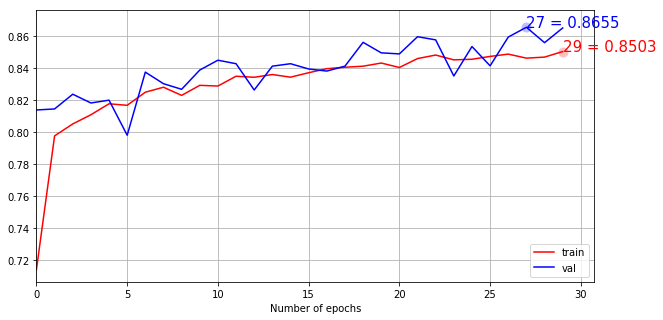

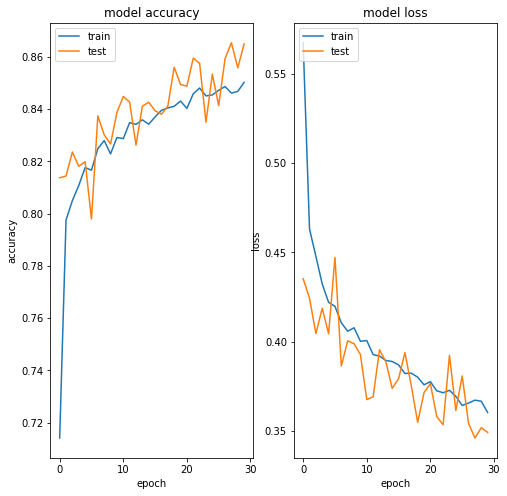


Epoch: 27 , Accuracy: 0.86546886


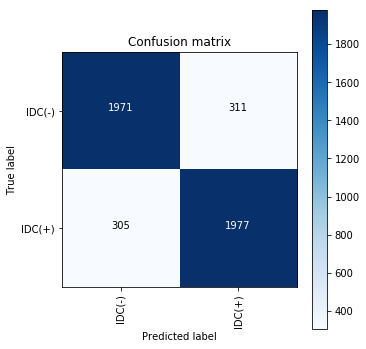

In [18]:
def runKerasCNN(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,64) -> maxpooling ->dense(256) with 3 dropout

Epoch 1/30
583/583 [==============================] - 23s 39ms/step - loss: 0.6086 - acc: 0.6663 - val_loss: 0.4869 - val_acc: 0.7739
Epoch 2/30
583/583 [==============================] - 22s 38ms/step - loss: 0.4795 - acc: 0.7849 - val_loss: 0.4370 - val_acc: 0.8107
Epoch 3/30
583/583 [==============================] - 22s 38ms/step - loss: 0.4568 - acc: 0.8015 - val_loss: 0.4226 - val_acc: 0.8234
Epoch 4/30
583/583 [==============================] - 22s 38ms/step - loss: 0.4427 - acc: 0.8079 - val_loss: 0.4255 - val_acc: 0.8192
Epoch 5/30
583/583 [==============================] - 22s 38ms/step - loss: 0.4335 - acc: 0.8127 - val_loss: 0.4024 - val_acc: 0.8269
Epoch 6/30
583/583 [==============================] - 23s 39ms/step - loss: 0.4296 - acc: 0.8150 - val_loss: 0.4083 - val_acc: 0.8276
Epoch 7/30
583/583 [==============================] - 22s 38ms/step - loss: 0.4208 - acc: 0.8188 - val_loss: 0.4121 - val_acc: 0.8258
Epoch 8/30
583/583 [==============================] - 22s 38ms

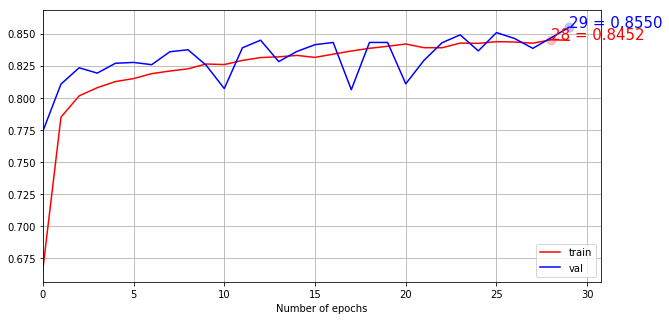

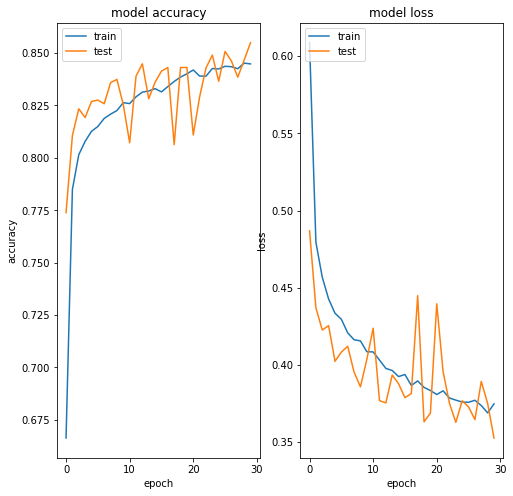


Epoch: 29 , Accuracy: 0.8549518


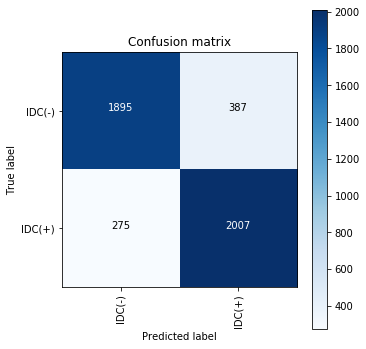

In [19]:
def runKerasCNNa(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data =(c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNa(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,128) -> maxpooling ->dense(256) with 3 dropout

Epoch 1/30
583/583 [==============================] - 25s 42ms/step - loss: 0.5946 - acc: 0.6855 - val_loss: 0.4765 - val_acc: 0.7932
Epoch 2/30
583/583 [==============================] - 24s 42ms/step - loss: 0.4730 - acc: 0.7924 - val_loss: 0.4545 - val_acc: 0.7954
Epoch 3/30
583/583 [==============================] - 24s 42ms/step - loss: 0.4482 - acc: 0.8075 - val_loss: 0.4115 - val_acc: 0.8208
Epoch 4/30
583/583 [==============================] - 24s 42ms/step - loss: 0.4370 - acc: 0.8092 - val_loss: 0.4298 - val_acc: 0.8168
Epoch 5/30
583/583 [==============================] - 24s 41ms/step - loss: 0.4297 - acc: 0.8163 - val_loss: 0.4088 - val_acc: 0.8230
Epoch 6/30
583/583 [==============================] - 24s 42ms/step - loss: 0.4221 - acc: 0.8210 - val_loss: 0.3923 - val_acc: 0.8302
Epoch 7/30
583/583 [==============================] - 24s 41ms/step - loss: 0.4182 - acc: 0.8225 - val_loss: 0.4062 - val_acc: 0.8379
Epoch 8/30
583/583 [==============================] - 24s 42ms

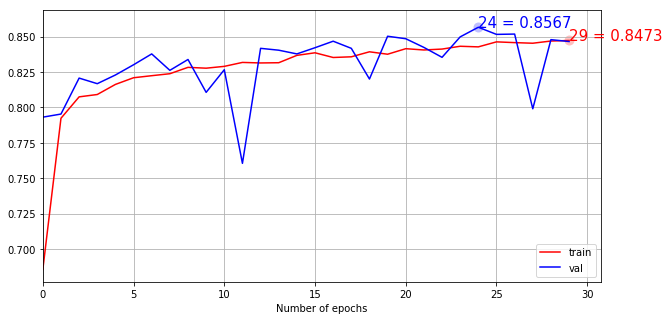

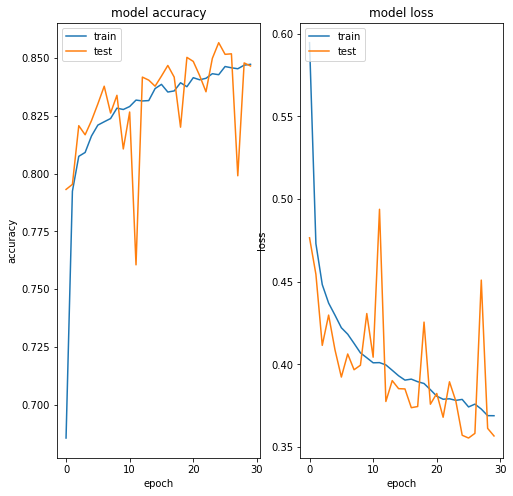


Epoch: 25 , Accuracy: 0.8516652


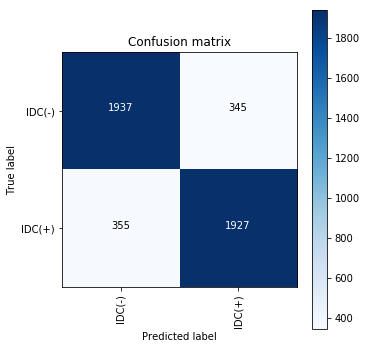

In [20]:
def runKerasCNNb(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNb(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,128) -> maxpooling ->dense(256) with 3 dropout and 2 BatchNormalization

Epoch 1/30
583/583 [==============================] - 30s 51ms/step - loss: 0.6153 - acc: 0.7679 - val_loss: 0.5035 - val_acc: 0.7846
Epoch 2/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4511 - acc: 0.8080 - val_loss: 0.9139 - val_acc: 0.5686
Epoch 3/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4329 - acc: 0.8168 - val_loss: 0.4233 - val_acc: 0.8350
Epoch 4/30
583/583 [==============================] - 29s 51ms/step - loss: 0.4216 - acc: 0.8227 - val_loss: 0.4781 - val_acc: 0.8232
Epoch 5/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4175 - acc: 0.8246 - val_loss: 0.4965 - val_acc: 0.8017
Epoch 6/30
583/583 [==============================] - 29s 51ms/step - loss: 0.4178 - acc: 0.8258 - val_loss: 0.4478 - val_acc: 0.8157
Epoch 7/30
583/583 [==============================] - 29s 50ms/step - loss: 0.4141 - acc: 0.8278 - val_loss: 6.1439 - val_acc: 0.5079
Epoch 8/30
583/583 [==============================] - 30s 51ms

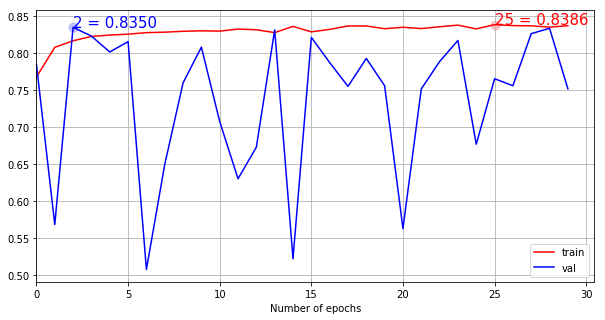

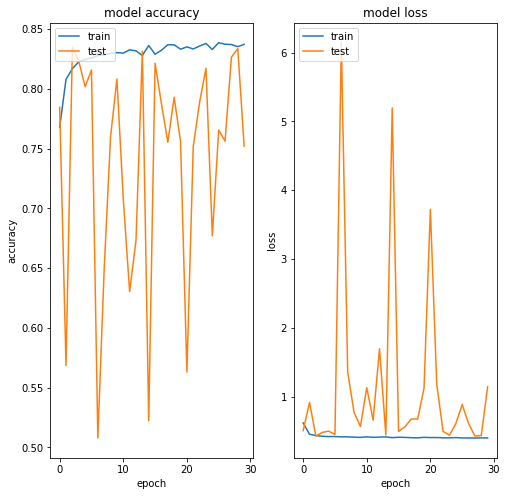


Epoch: 2 , Accuracy: 0.83501315


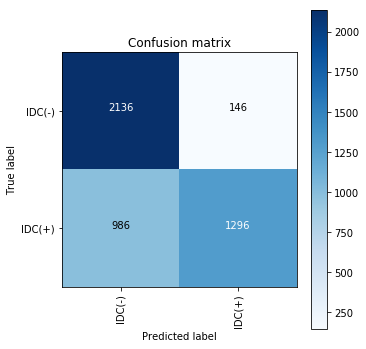

In [21]:
def runKerasCNNb(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNb(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,128) -> maxpooling ->dense(256)

Epoch 1/30
583/583 [==============================] - 24s 41ms/step - loss: 0.6051 - acc: 0.6642 - val_loss: 0.4529 - val_acc: 0.8057
Epoch 2/30
583/583 [==============================] - 24s 41ms/step - loss: 0.4785 - acc: 0.7854 - val_loss: 0.4391 - val_acc: 0.8142
Epoch 3/30
583/583 [==============================] - 24s 40ms/step - loss: 0.4505 - acc: 0.8023 - val_loss: 0.4167 - val_acc: 0.8223
Epoch 4/30
583/583 [==============================] - 24s 40ms/step - loss: 0.4330 - acc: 0.8121 - val_loss: 0.3997 - val_acc: 0.8352
Epoch 5/30
583/583 [==============================] - 24s 41ms/step - loss: 0.4256 - acc: 0.8148 - val_loss: 0.4087 - val_acc: 0.8243
Epoch 6/30
583/583 [==============================] - 24s 41ms/step - loss: 0.4201 - acc: 0.8182 - val_loss: 0.4014 - val_acc: 0.8330
Epoch 7/30
583/583 [==============================] - 24s 41ms/step - loss: 0.4119 - acc: 0.8233 - val_loss: 0.4194 - val_acc: 0.8168
Epoch 8/30
583/583 [==============================] - 24s 41ms

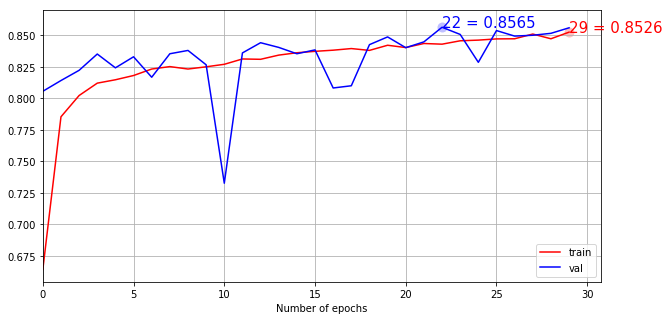

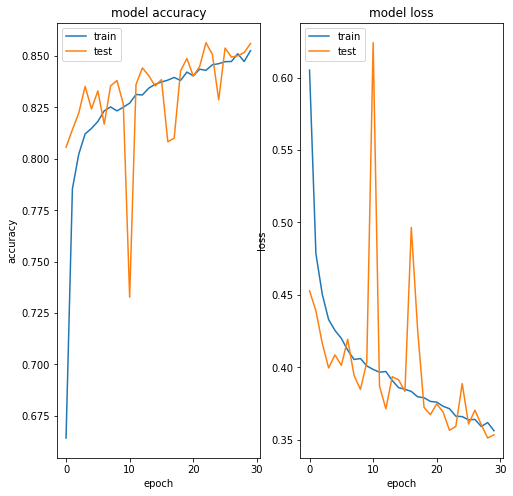


Epoch: 28 , Accuracy: 0.8516652


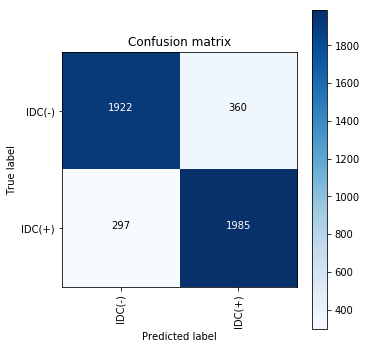

In [22]:
def runKerasCNNe(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNe(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

2 convolution layer(64,64) -> maxpooling ->2 convolution layer(128,128) -> maxpooling ->dense(256)

Epoch 1/30
583/583 [==============================] - 46s 78ms/step - loss: 0.5961 - acc: 0.6825 - val_loss: 0.4934 - val_acc: 0.7721
Epoch 2/30
583/583 [==============================] - 45s 77ms/step - loss: 0.4770 - acc: 0.7890 - val_loss: 0.4547 - val_acc: 0.8184
Epoch 3/30
583/583 [==============================] - 45s 78ms/step - loss: 0.4530 - acc: 0.7985 - val_loss: 0.4169 - val_acc: 0.8243
Epoch 4/30
583/583 [==============================] - 45s 78ms/step - loss: 0.4360 - acc: 0.8064 - val_loss: 0.4044 - val_acc: 0.8212
Epoch 5/30
583/583 [==============================] - 45s 77ms/step - loss: 0.4307 - acc: 0.8100 - val_loss: 0.4371 - val_acc: 0.8127
Epoch 6/30
583/583 [==============================] - 45s 78ms/step - loss: 0.4179 - acc: 0.8204 - val_loss: 0.3937 - val_acc: 0.8357
Epoch 7/30
583/583 [==============================] - 45s 77ms/step - loss: 0.4187 - acc: 0.8184 - val_loss: 0.4028 - val_acc: 0.8241
Epoch 8/30
583/583 [==============================] - 45s 77ms

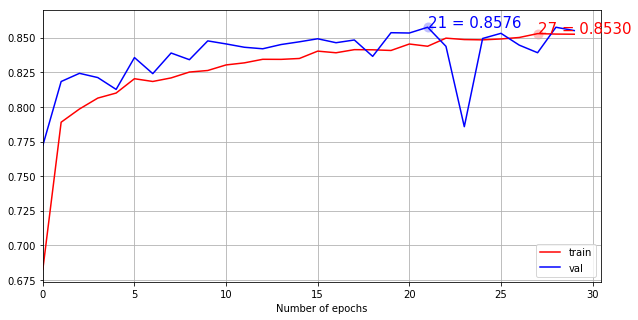

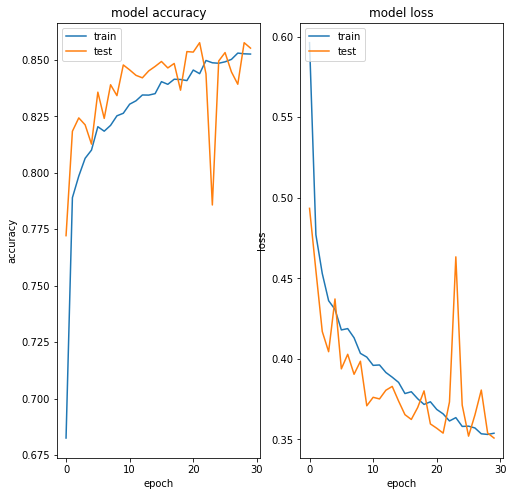


Epoch: 29 , Accuracy: 0.8551709


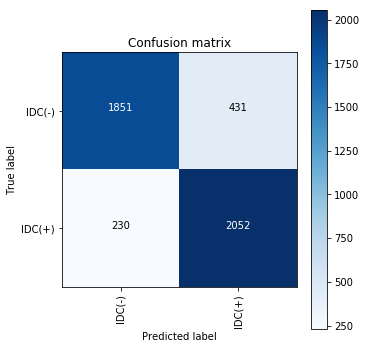

In [23]:
def runKerasCNNf(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3),
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNf(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

2 convolution layer(64,64) -> maxpooling ->3 convolution layer(128,128,128) -> maxpooling ->dense(256)

Epoch 1/30
583/583 [==============================] - 48s 83ms/step - loss: 0.6027 - acc: 0.6722 - val_loss: 0.4617 - val_acc: 0.8046
Epoch 2/30
583/583 [==============================] - 48s 82ms/step - loss: 0.4856 - acc: 0.7824 - val_loss: 0.4356 - val_acc: 0.8105
Epoch 3/30
583/583 [==============================] - 48s 82ms/step - loss: 0.4607 - acc: 0.7947 - val_loss: 0.4347 - val_acc: 0.8076
Epoch 4/30
583/583 [==============================] - 48s 82ms/step - loss: 0.4421 - acc: 0.8032 - val_loss: 0.4051 - val_acc: 0.8252
Epoch 5/30
583/583 [==============================] - 48s 82ms/step - loss: 0.4350 - acc: 0.8083 - val_loss: 0.5201 - val_acc: 0.7524
Epoch 6/30
583/583 [==============================] - 48s 83ms/step - loss: 0.4254 - acc: 0.8118 - val_loss: 0.4227 - val_acc: 0.8269
Epoch 7/30
583/583 [==============================] - 48s 82ms/step - loss: 0.4140 - acc: 0.8204 - val_loss: 0.3957 - val_acc: 0.8254
Epoch 8/30
583/583 [==============================] - 48s 83ms

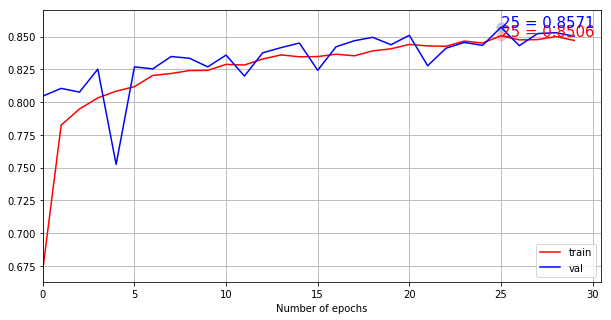

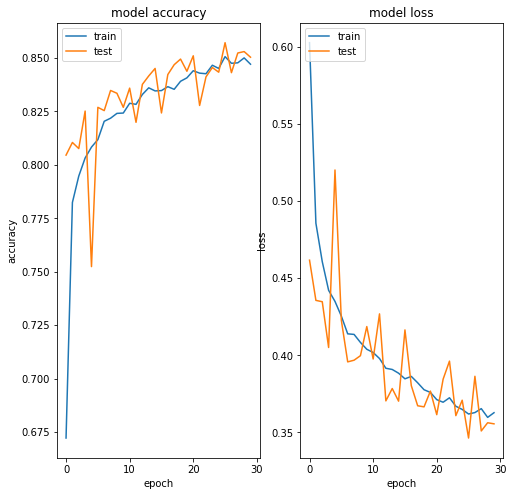


Epoch: 25 , Accuracy: 0.85714287


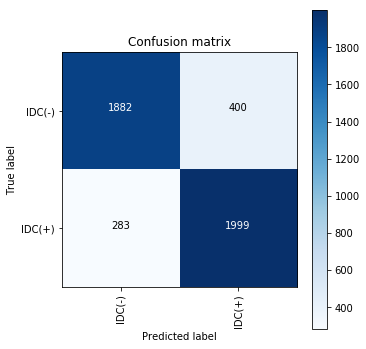

In [24]:
def runKerasCNNg(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3),
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNg(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

Below is the VGG16.

In [5]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(250, 250, 3))

Take a look at the layers of the model.

In [6]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

Because the model doesn't learn if I use the small size of the photo. As shown below, I will preprocess the images agian to a bigger size like 250 * 250 * 3.

In [7]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 250
    HEIGHT = 250
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

Because of the time limiation, I will choose 10000 images.

In [8]:
X,Y = proc_images(0,10000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

Split the data to training data and validation data.

In [9]:
X=np.array(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:30000] 
Y_train = Y_train[0:30000]
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (8000, 250, 250, 3)
Testing Data Shape: (2000, 250, 250, 3)


In [10]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 250,250,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 250,250,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

Epoch 1/15
124/124 [==============================] - 2748s 22s/step - loss: 0.5434 - acc: 0.7635 - val_loss: 0.3506 - val_acc: 0.8487
Epoch 2/15
124/124 [==============================] - 2604s 21s/step - loss: 0.4215 - acc: 0.8246 - val_loss: 0.3265 - val_acc: 0.8712
Epoch 3/15
124/124 [==============================] - 2586s 21s/step - loss: 0.3837 - acc: 0.8454 - val_loss: 0.3029 - val_acc: 0.8885
Epoch 4/15
124/124 [==============================] - 2590s 21s/step - loss: 0.3538 - acc: 0.8619 - val_loss: 0.3198 - val_acc: 0.8783
Epoch 5/15
124/124 [==============================] - 2593s 21s/step - loss: 0.3420 - acc: 0.8657 - val_loss: 0.2845 - val_acc: 0.8957
Epoch 6/15
124/124 [==============================] - 2604s 21s/step - loss: 0.3314 - acc: 0.8721 - val_loss: 0.3481 - val_acc: 0.8834
Epoch 7/15
124/124 [==============================] - 2598s 21s/step - loss: 0.3181 - acc: 0.8723 - val_loss: 0.2759 - val_acc: 0.8906
Epoch 8/15
124/124 [==============================] - 2

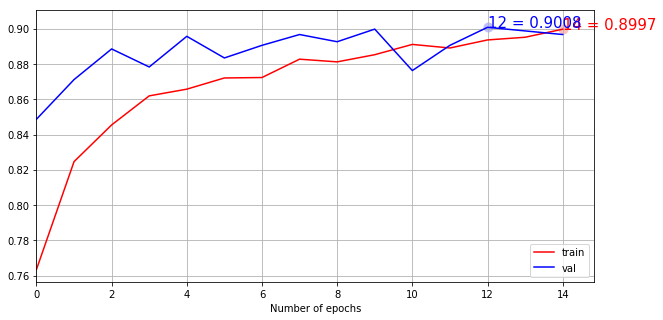

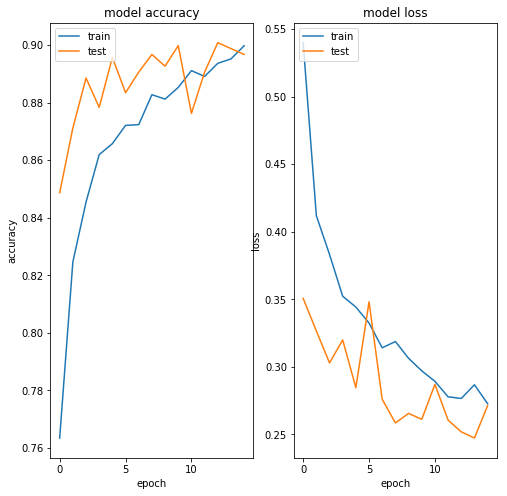


Epoch: 13 , Accuracy: 0.898773


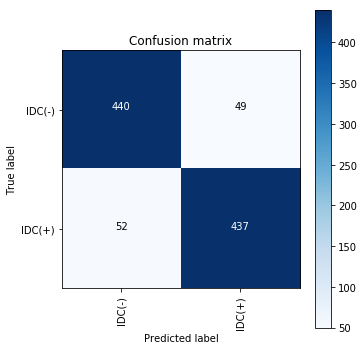

In [87]:
from tensorflow.keras import models

def runKerasCNNd(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 15
    model = models.Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                        steps_per_epoch=len(a) / 32, epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNd(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td></td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>3 convolution layer(32,64,128) -> maxpooling ->dense(256) with 2 dropout</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>86.55%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,64) -> maxpooling ->dense(256) with 3 dropout</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.5%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,128) -> maxpooling ->dense(256) with 3 dropout</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.67%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,128) -> maxpooling ->dense(256) with 3 dropout and 2 BatchNormalization</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>83.5%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,128) -> maxpooling ->dense(256)</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.65%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(64,64) -> maxpooling ->2 convolution layer(128,128) -> maxpooling ->dense(256)</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.76%</td>
        <td>6</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(64,64) -> maxpooling ->3 convolution layer(128,128,128) -> maxpooling ->dense(256)</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.71%</td>
        <td>7</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>categorical_crossentropy</td>
        <td>15</td>
        <td>VGG16</td>
        <td>RMSprop</td>
        <td>none</td>
        <td>90.08%</td>
        <td>7</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
        <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>15</td>
        <td>VGG16</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>50%</td>
        <td></td>
        <td>It doesn't learn</td>
    </tr>
</table>

The training data made up of large size of images may have a better performance on the accuracy.

<h2>Part G</h2>
- Network initialization

How does it effect the accuracy?<br/>
How does it effect how quickly the network plateaus?

In Part G, I will change the network initialization which is the only parameter I will change and compare them how to effect the accuracy and how quickly the wetwork plateaus.

kernel_initializer: random_uniform in the dense.

Epoch 1/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1956 - acc: 0.7024 - val_loss: 0.1375 - val_acc: 0.8146
Epoch 2/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1454 - acc: 0.7996 - val_loss: 0.1477 - val_acc: 0.7984
Epoch 3/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1366 - acc: 0.8131 - val_loss: 0.1298 - val_acc: 0.8208
Epoch 4/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1324 - acc: 0.8195 - val_loss: 0.1220 - val_acc: 0.8328
Epoch 5/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1315 - acc: 0.8207 - val_loss: 0.1202 - val_acc: 0.8363
Epoch 6/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1274 - acc: 0.8253 - val_loss: 0.1363 - val_acc: 0.8225
Epoch 7/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1263 - acc: 0.8299 - val_loss: 0.1189 - val_acc: 0.8392
Epoch 8/30
583/583 [==============================] - 34s 58ms

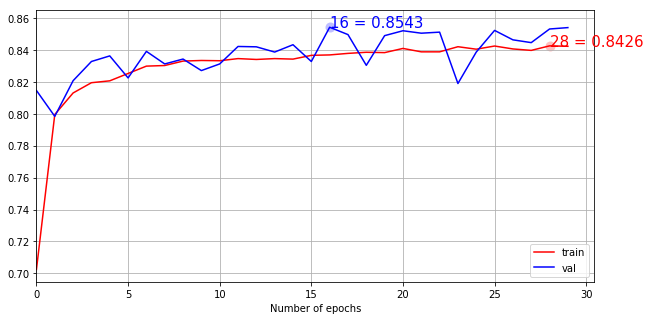

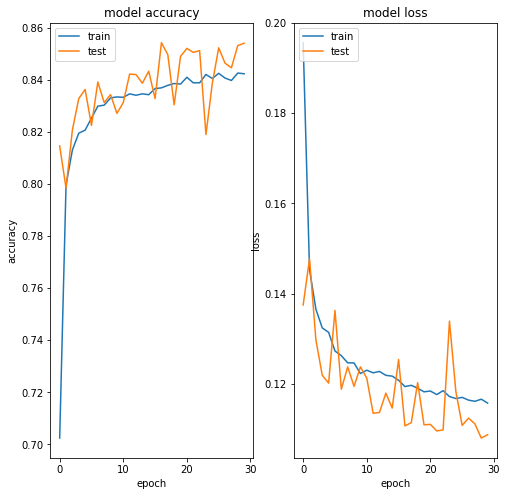


Epoch: 28 , Accuracy: 0.85319895


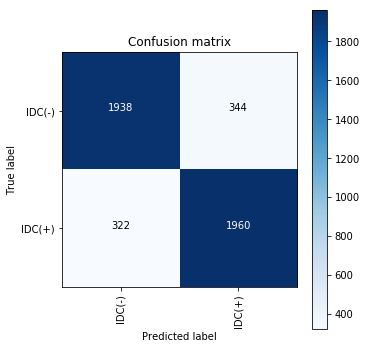

In [25]:
def runKerasCNN_11(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',kernel_initializer='random_uniform',
                bias_initializer='zeros'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_11(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

kernel_initializer: random_uniform in the convolution layers.

Epoch 1/30
583/583 [==============================] - 34s 58ms/step - loss: 0.2061 - acc: 0.6759 - val_loss: 0.1438 - val_acc: 0.8050
Epoch 2/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1486 - acc: 0.7939 - val_loss: 0.1300 - val_acc: 0.8186
Epoch 3/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1405 - acc: 0.8050 - val_loss: 0.1307 - val_acc: 0.8203
Epoch 4/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1362 - acc: 0.8112 - val_loss: 0.1254 - val_acc: 0.8291
Epoch 5/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1337 - acc: 0.8161 - val_loss: 0.1391 - val_acc: 0.7986
Epoch 6/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1329 - acc: 0.8195 - val_loss: 0.1222 - val_acc: 0.8348
Epoch 7/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1331 - acc: 0.8167 - val_loss: 0.1262 - val_acc: 0.8359
Epoch 8/30
583/583 [==============================] - 34s 58ms

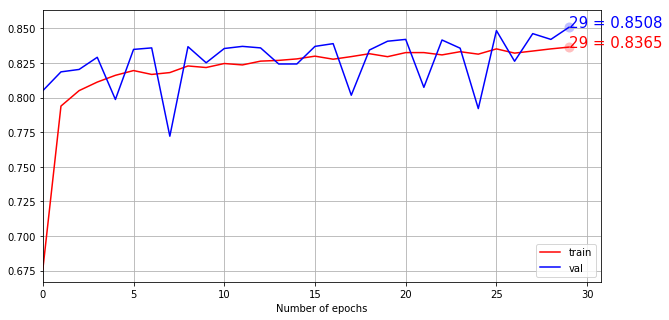

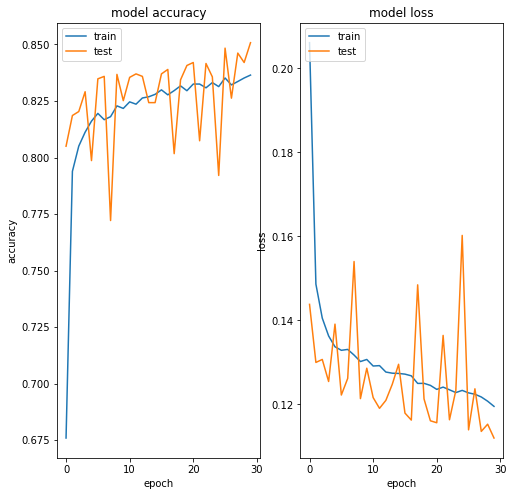


Epoch: 29 , Accuracy: 0.8507888


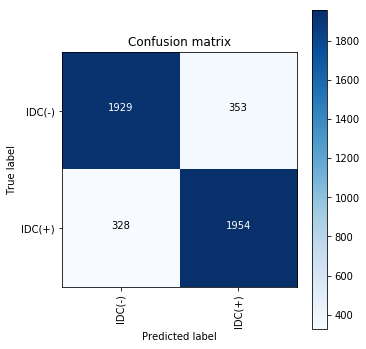

In [26]:
def runKerasCNN_111(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     kernel_initializer='random_uniform',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3),kernel_initializer='random_uniform',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_111(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

kernel_initializer: random_uniform in both dense and convolution layers.

Epoch 1/30
583/583 [==============================] - 34s 59ms/step - loss: 0.2081 - acc: 0.6718 - val_loss: 0.1482 - val_acc: 0.7824
Epoch 2/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1480 - acc: 0.7973 - val_loss: 0.1373 - val_acc: 0.8201
Epoch 3/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1392 - acc: 0.8101 - val_loss: 0.1288 - val_acc: 0.8258
Epoch 4/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1363 - acc: 0.8139 - val_loss: 0.1401 - val_acc: 0.8024
Epoch 5/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1336 - acc: 0.8162 - val_loss: 0.1284 - val_acc: 0.8252
Epoch 6/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1330 - acc: 0.8174 - val_loss: 0.1232 - val_acc: 0.8326
Epoch 7/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1306 - acc: 0.8218 - val_loss: 0.1248 - val_acc: 0.8309
Epoch 8/30
583/583 [==============================] - 34s 58ms

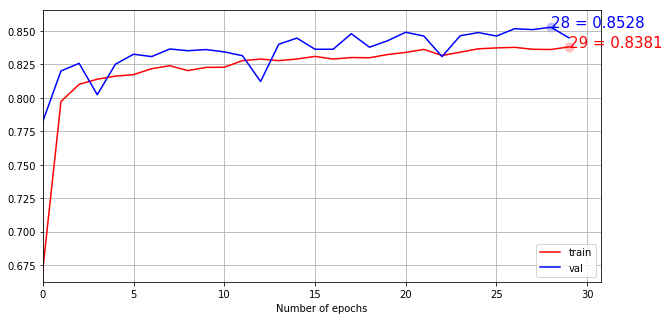

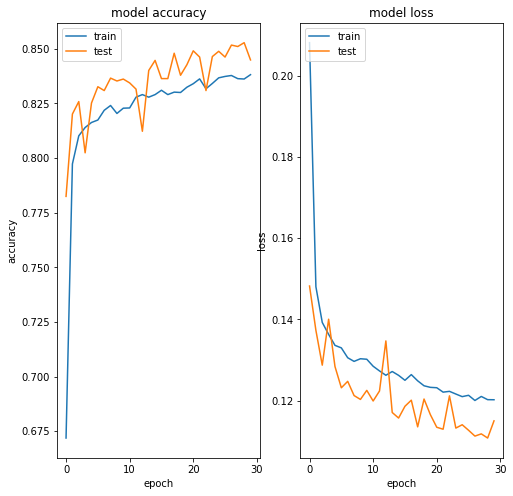


Epoch: 28 , Accuracy: 0.85276073


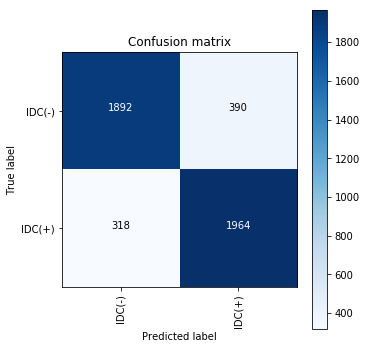

In [27]:
def runKerasCNN_112(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     kernel_initializer='random_uniform',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), kernel_initializer='random_uniform',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer='random_uniform',
              activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, kernel_initializer='random_uniform',activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data =(c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_112(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

kernel_initializer: zeros in the dense and convolution layers.

Epoch 1/30
583/583 [==============================] - 34s 58ms/step - loss: 0.2500 - acc: 0.5059 - val_loss: 0.2500 - val_acc: 0.5000
Epoch 2/30
583/583 [==============================] - 34s 58ms/step - loss: 0.2500 - acc: 0.4968 - val_loss: 0.2500 - val_acc: 0.5000
Epoch 3/30
583/583 [==============================] - 34s 58ms/step - loss: 0.2500 - acc: 0.4992 - val_loss: 0.2500 - val_acc: 0.5000
Epoch 4/30
583/583 [==============================] - 34s 58ms/step - loss: 0.2500 - acc: 0.4990 - val_loss: 0.2500 - val_acc: 0.5000
Epoch 5/30
583/583 [==============================] - 34s 58ms/step - loss: 0.2500 - acc: 0.4990 - val_loss: 0.2500 - val_acc: 0.5000
Epoch 6/30
583/583 [==============================] - 34s 58ms/step - loss: 0.2500 - acc: 0.5041 - val_loss: 0.2500 - val_acc: 0.5000
Epoch 7/30
583/583 [==============================] - 34s 58ms/step - loss: 0.2500 - acc: 0.4992 - val_loss: 0.2500 - val_acc: 0.5000
Epoch 8/30
583/583 [==============================] - 34s 58ms

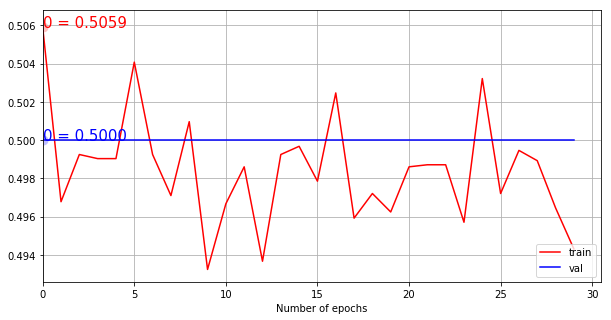

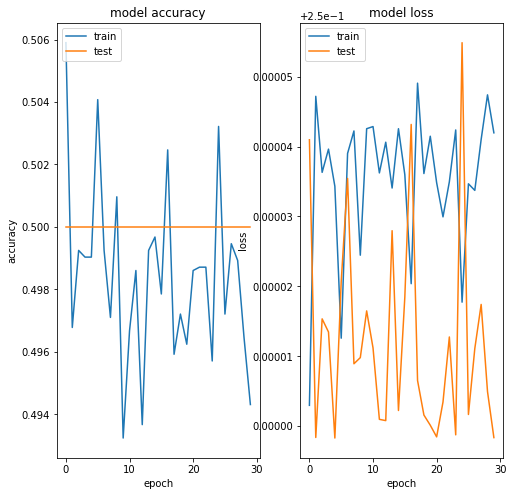


Epoch: 4 , Accuracy: 0.5


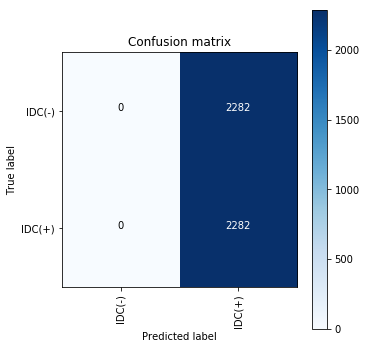

In [28]:
def runKerasCNN_113(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3),
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer='Zeros', 
                    activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, kernel_initializer='Zeros',activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_113(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

kernel_initializer: glorot_normal in the convolution layers.

Epoch 1/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1903 - acc: 0.7131 - val_loss: 0.1588 - val_acc: 0.7778
Epoch 2/30
583/583 [==============================] - 34s 58ms/step - loss: 0.1457 - acc: 0.7982 - val_loss: 0.1329 - val_acc: 0.8199
Epoch 3/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1397 - acc: 0.8068 - val_loss: 0.1367 - val_acc: 0.8129
Epoch 4/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1366 - acc: 0.8111 - val_loss: 0.1449 - val_acc: 0.8050
Epoch 5/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1332 - acc: 0.8181 - val_loss: 0.1257 - val_acc: 0.8284
Epoch 6/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1324 - acc: 0.8190 - val_loss: 0.1219 - val_acc: 0.8313
Epoch 7/30
583/583 [==============================] - 34s 59ms/step - loss: 0.1294 - acc: 0.8227 - val_loss: 0.1278 - val_acc: 0.8234
Epoch 8/30
583/583 [==============================] - 35s 60ms

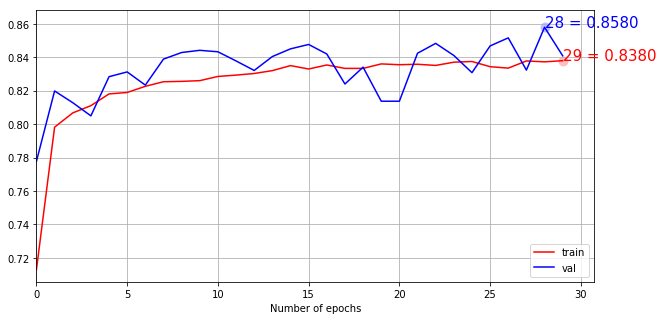

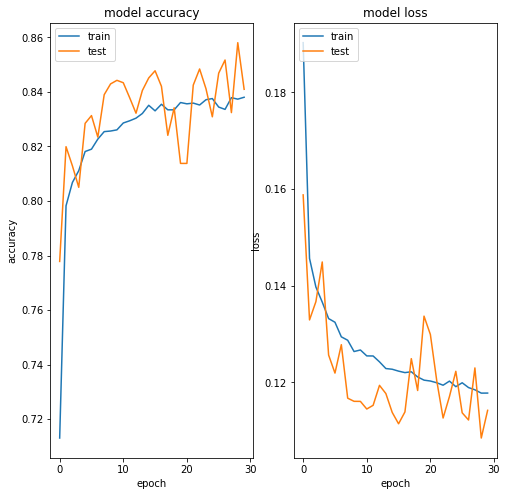


Epoch: 28 , Accuracy: 0.8580193


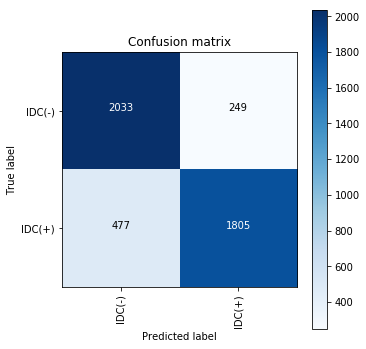

In [29]:
def runKerasCNN_113(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     kernel_initializer='glorot_normal',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3),kernel_initializer='glorot_normal',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_113(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

kernel_initializer: glorot_uniform in the convolution layers.

Epoch 1/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1904 - acc: 0.7192 - val_loss: 0.1412 - val_acc: 0.7921
Epoch 2/30
583/583 [==============================] - 35s 59ms/step - loss: 0.1467 - acc: 0.7979 - val_loss: 0.1336 - val_acc: 0.8170
Epoch 3/30
583/583 [==============================] - 35s 59ms/step - loss: 0.1388 - acc: 0.8085 - val_loss: 0.1316 - val_acc: 0.8199
Epoch 4/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1361 - acc: 0.8159 - val_loss: 0.1291 - val_acc: 0.8238
Epoch 5/30
583/583 [==============================] - 35s 59ms/step - loss: 0.1327 - acc: 0.8167 - val_loss: 0.1277 - val_acc: 0.8245
Epoch 6/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1319 - acc: 0.8164 - val_loss: 0.1403 - val_acc: 0.8063
Epoch 7/30
583/583 [==============================] - 35s 59ms/step - loss: 0.1310 - acc: 0.8189 - val_loss: 0.1294 - val_acc: 0.8192
Epoch 8/30
583/583 [==============================] - 35s 60ms

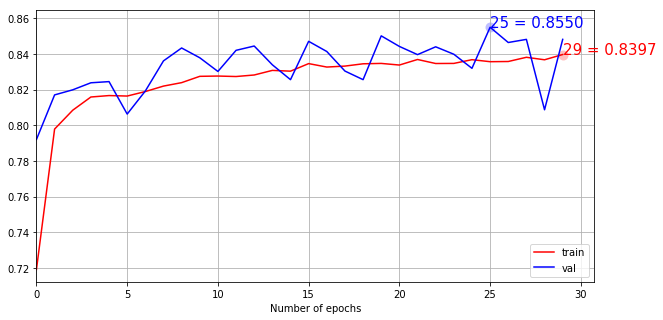

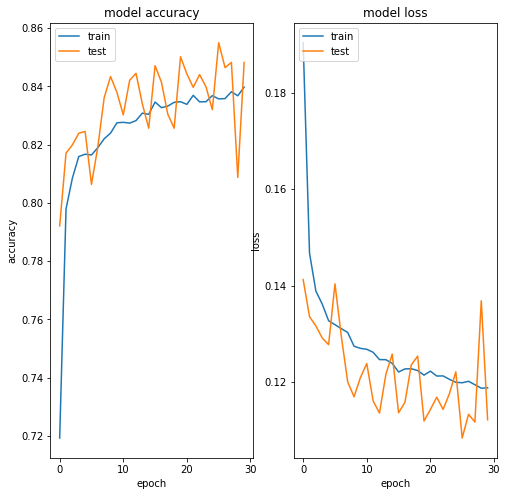


Epoch: 25 , Accuracy: 0.8549518


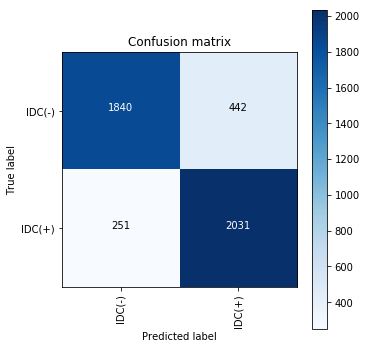

In [30]:
def runKerasCNN_114(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     kernel_initializer='glorot_uniform',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3),kernel_initializer='glorot_uniform',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_114(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

kernel_initializer: glorot_uniform in both dense and convolution layers.

Epoch 1/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1941 - acc: 0.7032 - val_loss: 0.1406 - val_acc: 0.8096
Epoch 2/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1458 - acc: 0.7967 - val_loss: 0.1496 - val_acc: 0.7965
Epoch 3/30
583/583 [==============================] - 35s 59ms/step - loss: 0.1402 - acc: 0.8079 - val_loss: 0.1288 - val_acc: 0.8256
Epoch 4/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1367 - acc: 0.8124 - val_loss: 0.1345 - val_acc: 0.8230
Epoch 5/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1339 - acc: 0.8161 - val_loss: 0.1429 - val_acc: 0.8046
Epoch 6/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1323 - acc: 0.8170 - val_loss: 0.1291 - val_acc: 0.8238
Epoch 7/30
583/583 [==============================] - 35s 60ms/step - loss: 0.1302 - acc: 0.8212 - val_loss: 0.1347 - val_acc: 0.8175
Epoch 8/30
583/583 [==============================] - 35s 60ms

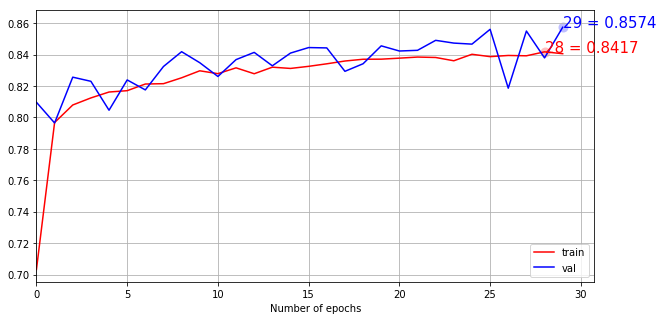

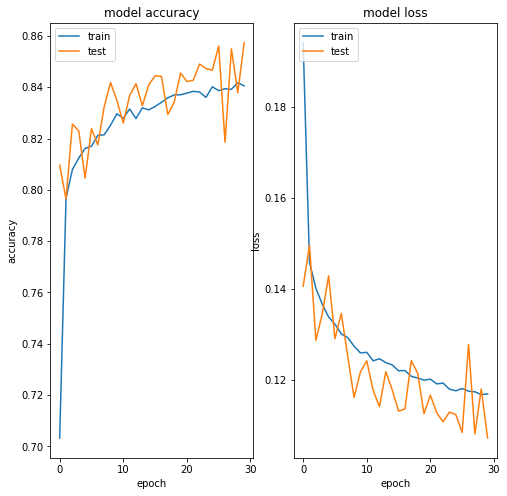


Epoch: 29 , Accuracy: 0.857362


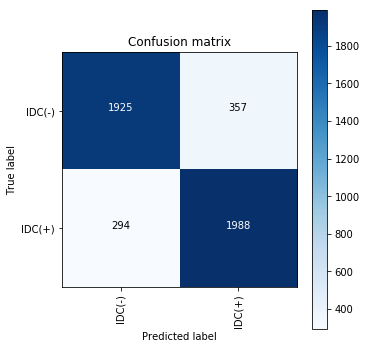

In [31]:
def runKerasCNN_115(a,b,c,d,e,f):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 32
    num_classes = 2
    epochs = 30
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     kernel_initializer='glorot_uniform',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None),
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3),kernel_initializer='glorot_uniform',
                     activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, kernel_initializer='glorot_uniform',activation=tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=None)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, kernel_initializer='glorot_uniform',activation='softmax'))
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=batch_size),
                       steps_per_epoch=len(a) / 32,epochs=epochs,class_weight=f, validation_data = (c, d),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    print('\nEpoch:',val_loss.index(min(val_loss)),', Accuracy:',val_acc[val_loss.index(min(val_loss))])
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNN_115(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td></td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: random_uniform in the dense</td>
        <td>85.43%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: random_uniform in the convolution layers</td>
        <td>85.08%</td>
        <td>2</td>
        <td>It doesn't change the speed of model reaching the network plateaus, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: zeros in the dense and convolution layers</td>
        <td>50%</td>
        <td></td>
        <td>It doesn't learn</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: glorot_normal in the convolution layers</td>
        <td>85.8%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: glorot_uniform in the convolution layers</td>
        <td>85.5%</td>
        <td>1</td>
        <td>It makes model reach the network plateaus quicker, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: glorot_uniform in both dense and convolution layers</td>
        <td>85.74%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
</table>

Except the zeros, we can see add kernel_initializer can increase the accuracy up to more than 85%.

<h2>Conclusion</h2>

Activation function

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Rectified linear unit (ReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.38%</td>
        <td>7</td>
        <td>The best activation function for the model</td>
    </tr>
    <tr>
        <td>tanh</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.95%</td>
        <td>10</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Leaky rectified linear unit (Leaky ReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>83.92</td>
        <td>6</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.31%</td>
        <td>6</td>
        <td>It makes model reach the network plateaus quicker, but a little decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Exponential linear unit (ELU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.76%</td>
        <td>10</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>  
    <tr>
        <td>Scaled exponential linear unit (SELU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.89%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
     <tr>
        <td>Softplus</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.30%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
     <tr>
        <td>softsign</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>83.02%</td>
        <td>10</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
     <tr>
        <td>exponential</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>50%</td>
        <td></td>
        <td>Not learning, not suitable for the model</td>
    </tr>
</table>

Cost function

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.31%</td>
        <td>6</td>
        <td>Contrast model</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td>It makes model reach the network plateaus quicker, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>hinge</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>81.82%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>kullback_leibler_divergence</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.48%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus quicker, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>cosine_proximity </td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.88%</td>
        <td>1</td>
        <td>It makes model reach the network plateaus quicker, and increase the accuracy which is best model.</td>
    </tr>  
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>binary_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.11%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
     <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>categorical_crossentropy</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>82.30%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus quicker, but decrease the accuracy.</td>
    </tr>
</table>

Epochs

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td></td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>200</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>87.30%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
</table>

Gradient estimation

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td></td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Stochastic Gradient Descent</td>
        <td>none</td>
        <td>82.87%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adagrad</td>
        <td>none</td>
        <td>84.09%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>RMSprop</td>
        <td>none</td>
        <td>84.86%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adam</td>
        <td>none</td>
        <td>84.22%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adamax</td>
        <td>none</td>
        <td>85.01%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy which is the best parameter</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Nadam</td>
        <td>none</td>
        <td>50%</td>
        <td></td>
        <td>It dones't learn</td>
    </tr>
</table>

Network Architecture

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td></td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>3 convolution layer(32,64,128) -> maxpooling ->dense(256) with 2 dropout</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>86.55%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,64) -> maxpooling ->dense(256) with 3 dropout</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.5%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,128) -> maxpooling ->dense(256) with 3 dropout</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.67%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,128) -> maxpooling ->dense(256) with 3 dropout and 2 BatchNormalization</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>83.5%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus later, but decrease the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(32,32) -> maxpooling ->2 convolution layer(64,128) -> maxpooling ->dense(256)</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.65%</td>
        <td>4</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(64,64) -> maxpooling ->2 convolution layer(128,128) -> maxpooling ->dense(256)</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.76%</td>
        <td>6</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layer(64,64) -> maxpooling ->3 convolution layer(128,128,128) -> maxpooling ->dense(256)</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>85.71%</td>
        <td>7</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>relu</td>
        <td>categorical_crossentropy</td>
        <td>15</td>
        <td>VGG16</td>
        <td>RMSprop</td>
        <td>none</td>
        <td>90.08%</td>
        <td>7</td>
        <td>It makes model reach the network plateaus later, and increase the accuracy.</td>
    </tr>
        <tr>
        <td>relu</td>
        <td>mean_squared_error</td>
        <td>15</td>
        <td>VGG16</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>50%</td>
        <td></td>
        <td>It doesn't learn</td>
    </tr>
</table>

Network initialization

<table>
    <tr>
        <td>Activation Function</td>
        <td>Cost function</td>
        <td>Epochs</td>
        <td>Network Architecture</td>
        <td>Gradient estimation</td>
        <td>Network initialization</td>
        <td>Accuracy</td>
        <td>Plateaus</td>
        <td>Comments</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>none</td>
        <td>84.64%</td>
        <td>2</td>
        <td></td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: random_uniform in the dense</td>
        <td>85.43%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: random_uniform in the convolution layers</td>
        <td>85.08%</td>
        <td>2</td>
        <td>It doesn't change the speed of model reaching the network plateaus, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: zeros in the dense and convolution layers</td>
        <td>50%</td>
        <td></td>
        <td>It doesn't learn</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: glorot_normal in the convolution layers</td>
        <td>85.8%</td>
        <td>5</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: glorot_uniform in the convolution layers</td>
        <td>85.5%</td>
        <td>1</td>
        <td>It makes model reach the network plateaus quicker, and increase the accuracy.</td>
    </tr>
    <tr>
        <td>Parameteric rectified linear unit (PReLU)</td>
        <td>mean_squared_error</td>
        <td>30</td>
        <td>2 convolution layers, 1 MaxPooling, 2 Dropout and 1 dense</td>
        <td>Adadelta</td>
        <td>kernel_initializer: glorot_uniform in both dense and convolution layers</td>
        <td>85.74%</td>
        <td>3</td>
        <td>It makes model reach the network plateaus later, but increase the accuracy.</td>
    </tr>
</table>

Above are the details of the model and their results. I can find some rules, but I am not sure they are right or not. <br/>
If the training data are made up by larger size of images, the model will have better performance.<br/>
Large amount of training data and small numbers variables in model can effectivly control overfitting.<br/>
However, there are still many questions I am not sure, like why there are some model didn't learn.<br/>
By the way, because I only used the Keras first then changed it into tensorflow.keras. I find the accuracy only used Keras generally higher than tensorflow.keras.

<h2>Contributions</h2>

The part of preprocessing data and part A is the code from Predict IDC in Breast Cancer Histology Images : https://www.kaggle.com/paultimothymooney/predict-idc-in-breast-cancer-histology-images/data<br/>
The rest parts are done by Dingting Huang.

<h2>Citations</h2>

* Predict IDC in Breast Cancer Histology Images : https://www.kaggle.com/paultimothymooney/predict-idc-in-breast-cancer-histology-images/data
* An overview of gradient descent optimization algorithms http://ruder.io/optimizing-gradient-descent/
* Introduction to Loss Functions https://blog.algorithmia.com/introduction-to-loss-functions/
* Fundamentals of Deep Learning – Activation Functions and When to Use Them? https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/
* Understanding of Convolutional Neural Network (CNN) — Deep Learning https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148

<h2>License</h2>

Copyright <2019> Dingting Huang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

THE WORK (AS DEFINED BELOW) IS PROVIDED UNDER THE TERMS OF THIS CREATIVE COMMONS PUBLIC LICENSE ("CCPL" OR "LICENSE"). THE WORK IS PROTECTED BY COPYRIGHT AND/OR OTHER APPLICABLE LAW. ANY USE OF THE WORK OTHER THAN AS AUTHORIZED UNDER THIS LICENSE OR COPYRIGHT LAW IS PROHIBITED.

BY EXERCISING ANY RIGHTS TO THE WORK PROVIDED HERE, YOU ACCEPT AND AGREE TO BE BOUND BY THE TERMS OF THIS LICENSE. TO THE EXTENT THIS LICENSE MAY BE CONSIDERED TO BE A CONTRACT, THE LICENSOR GRANTS YOU THE RIGHTS CONTAINED HERE IN CONSIDERATION OF YOUR ACCEPTANCE OF SUCH TERMS AND CONDITIONS.